# Dataset Information

# Background

The World Health Organization (WHO) characterized the COVID-19, caused by the SARS-CoV-2, as a pandemic on March 11, while the exponential increase in the number of cases was risking to overwhelm health systems around the world with a demand for ICU beds far above the existing capacity, with regions of Italy being prominent examples.

Brazil recorded the first case of SARS-CoV-2 on February 26, and the virus transmission evolved from imported cases only, to local and finally community transmission very rapidly, with the federal government declaring nationwide community transmission on March 20.

Until March 27, the state of São Paulo had recorded 1,223 confirmed cases of COVID-19, with 68 related deaths, while the county of São Paulo, with a population of approximately 12 million people and where Hospital Israelita Albert Einstein is located, had 477 confirmed cases and 30 associated death, as of March 23. Both the state and the county of São Paulo decided to establish quarantine and social distancing measures, that will be enforced at least until early April, in an effort to slow the virus spread.

One of the motivations for this challenge is the fact that in the context of an overwhelmed health system with the possible limitation to perform tests for the detection of SARS-CoV-2, testing every case would be impractical and tests results could be delayed even if only a target subpopulation would be tested.

# Dataset

This dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

# Task

Predict admission to general ward, semi-intensive unit or intensive care unit among confirmed COVID-19 cases.
Based on the results of laboratory tests commonly collected among confirmed COVID-19 cases during a visit to the emergency room, would it be possible to predict which patients will need to be admitted to a general ward, semi-intensive unit or intensive care unit?

Dataset Extraction link : https://www.kaggle.com/einsteindata4u/covid19

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly
import plotly.express as px
import xgboost
import lazypredict

from prettytable import PrettyTable    

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from json_config_expander import expand_configs
from lazypredict.Supervised import LazyClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from numpy import loadtxt
from numpy import sort
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

%matplotlib notebook
%matplotlib inline

C:\Users\Hiroshi Tatara\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll=function(lines){
    return false;
}

<IPython.core.display.Javascript object>

# 1. Read dataset

In [3]:
covid_df= pd.read_excel("dataset.xlsx",engine='openpyxl')
covid_df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,126e9dd13932f68,17,negative,0,0,0,0.24,-0.02,-0.52,0.01,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,a46b4402a0e5696,8,negative,0,0,0,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,f7d619a94f97c45,5,negative,0,0,0,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,d9e41465789c2b5,15,negative,0,0,0,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [4]:
print ("Total Number of rows are",covid_df.shape[0],"and total number of columns are",str(covid_df.shape[1])+".")

Total Number of rows are 5644 and total number of columns are 111.


In [5]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


# 2. Initial Exploratory data analysis
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0244129

**Number of Patients Warded**

In [6]:
patient_reg=len(covid_df.loc[covid_df['Patient addmited to regular ward (1=yes, 0=no)']==1])
patient_semi=len(covid_df.loc[covid_df['Patient addmited to semi-intensive unit (1=yes, 0=no)']==1])
patient_intensive=len(covid_df.loc[covid_df['Patient addmited to intensive care unit (1=yes, 0=no)']==1])
patient_total=len(covid_df)
patient_ward=patient_reg+patient_semi+patient_intensive

In [7]:
print (str(round(patient_reg/patient_total*100,2))+"% of the patients are staying in regular ward.\n"
       +str(round(patient_semi/patient_total*100,2))+"% of the patients are staying in semi-intensive unit.\n"
      +str(round(patient_intensive/patient_total*100,2))+"% of the patients are staying in intensive care unit.\n"
      "There are a total of",str(round(patient_ward/patient_total*100,2))+"% of the patients warded in the hospital and",
      str(round((patient_total-patient_ward)/patient_total*100,2))+"% of the patients not warded.")

1.4% of the patients are staying in regular ward.
0.89% of the patients are staying in semi-intensive unit.
0.73% of the patients are staying in intensive care unit.
There are a total of 3.01% of the patients warded in the hospital and 96.99% of the patients not warded.


**2.1 Missing values**

In [8]:
print(str(round(covid_df.isna().sum().sum()/covid_df.size*100,2))+'% of the dataset has missing values.')

88.06% of the dataset has missing values.


<AxesSubplot:>

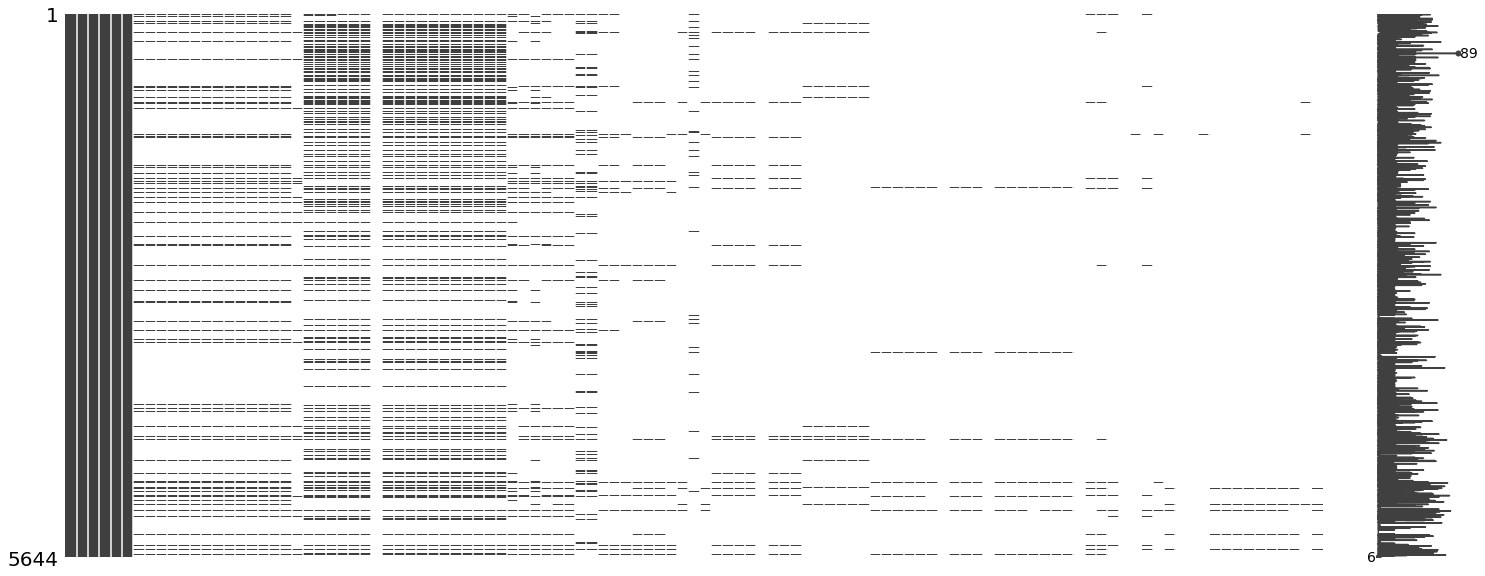

In [9]:
msno.matrix(covid_df)

**Observation :** As you can see from the missing number matrix above, you can easily see the missing number distributions. The first 6 columns have datas in all the rows, but it still does not provide us with enough details to decide which columns to drop. 

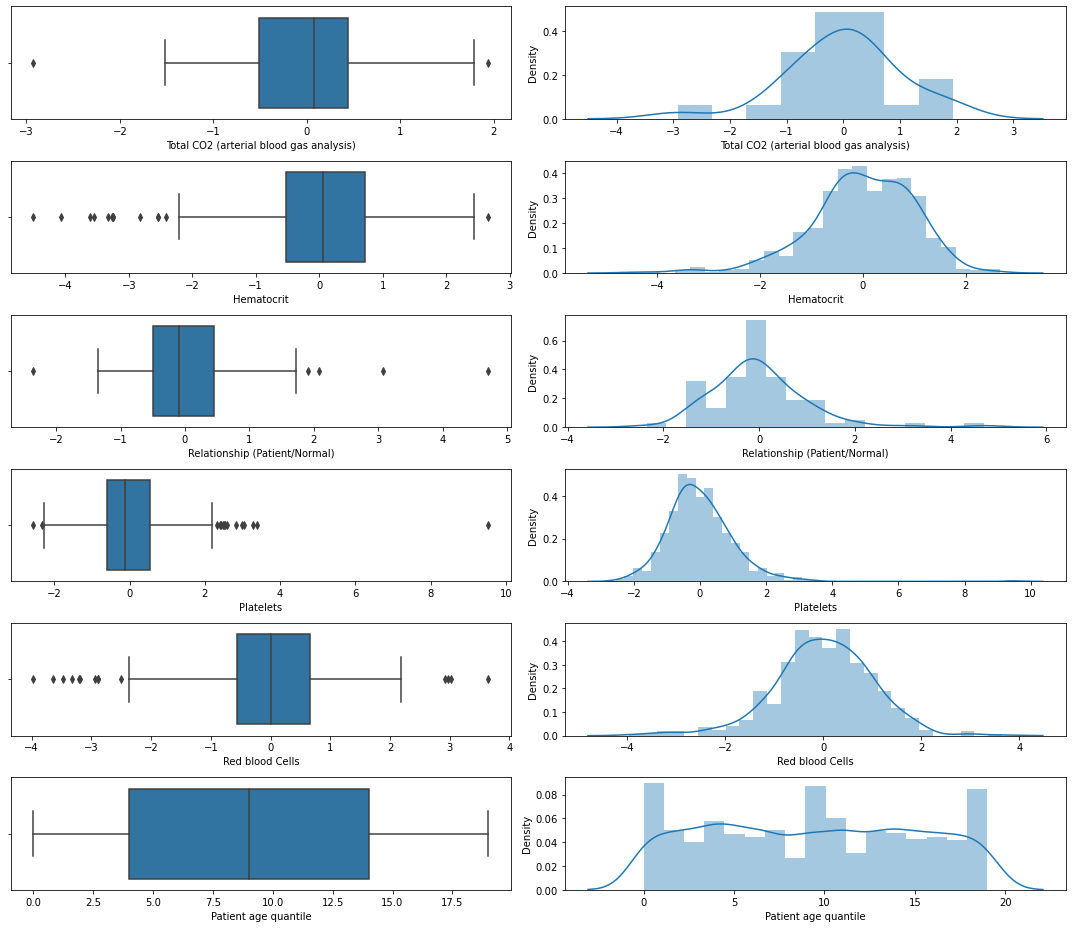

In [12]:
## Exploring the range and distribution of numerical Variables

fig, ax = plt.subplots(6, 2, figsize = (15, 13))
sns.boxplot(x= covid_df["Total CO2 (arterial blood gas analysis)"], ax = ax[0,0])
sns.distplot(covid_df['Total CO2 (arterial blood gas analysis)'], ax = ax[0,1])
sns.boxplot(x= covid_df["Hematocrit"], ax = ax[1,0])
sns.distplot(covid_df['Hematocrit'], ax = ax[1,1])
sns.boxplot(x= covid_df["Relationship (Patient/Normal)"], ax = ax[2,0])
sns.distplot(covid_df['Relationship (Patient/Normal)'], ax = ax[2,1])
sns.boxplot(x= covid_df["Platelets"], ax = ax[3,0])
sns.distplot(covid_df['Platelets'], ax = ax[3,1])
sns.boxplot(x= covid_df["Red blood Cells"], ax = ax[4,0])
sns.distplot(covid_df['Red blood Cells'], ax = ax[4,1])
sns.boxplot(x= covid_df["Patient age quantile"], ax = ax[5,0])
sns.distplot(covid_df['Patient age quantile'], ax = ax[5,1])
plt.tight_layout()

# 3. Data Preprocessing

In [15]:
#Create a new copy for data preprocessing
covid_new=covid_df.copy()

**3.1 Columns Missing Values**

In [16]:
pd.set_option('display.max_rows', covid_new.shape[0]+1) # To display all rows
pd.set_option('display.max_columns', covid_new.shape[1]+1) # To display all rows
covid_new.isna().sum().sort_values(ascending=False).head()

Prothrombin time (PT), Activity       5644
D-Dimer                               5644
Mycoplasma pneumoniae                 5644
Urine - Sugar                         5644
Partial thromboplastin time (PTT)     5644
dtype: int64

**3.1A Finding the weight of the missing data**

In [17]:
missing_datacol=(covid_new.isna().sum()/covid_new.shape[0]).sort_values(ascending=False).reset_index()
replace_col_list=['Column_name','Weightage']
missing_datacol.columns =replace_col_list
missing_datacol.head()

,Column_name,Weightage
0,"Prothrombin time (PT), Activity",1.00
1,D-Dimer,1.00
2,Mycoplasma pneumoniae,1.00
3,Urine - Sugar,1.00
4,Partial thromboplastin time (PTT),1.00


**3.1B Dropping of Columns**

In [18]:
drop_list=missing_datacol['Column_name'].loc[ missing_datacol['Weightage']>0.95].values.tolist()
#Add Patient ID to the drop list
drop_list.append('Patient ID')
covid_new=covid_new.drop(drop_list, axis = 1)

covid_new.shape
                                           

(5644, 45)

In [19]:
drop_list

['Prothrombin time (PT), Activity',
 'D-Dimer',
 'Mycoplasma pneumoniae',
 'Urine - Sugar',
 'Partial thromboplastin time\xa0(PTT)\xa0',
 'Fio2 (venous blood gas analysis)',
 'Urine - Nitrite',
 'Vitamin B12',
 'Lipase dosage',
 'Albumin',
 'Phosphor',
 'Arteiral Fio2',
 'Ferritin',
 'Base excess (arterial blood gas analysis)',
 'pO2 (arterial blood gas analysis)',
 'HCO3 (arterial blood gas analysis)',
 'pCO2 (arterial blood gas analysis)',
 'Total CO2 (arterial blood gas analysis)',
 'Arterial Lactic Acid',
 'pH (arterial blood gas analysis)',
 'Hb saturation (arterial blood gases)',
 'ctO2 (arterial blood gas analysis)',
 'Magnesium',
 'Ionized calcium\xa0',
 'Urine - Ketone Bodies',
 'Urine - Esterase',
 'Urine - Protein',
 'Urine - Hyaline cylinders',
 'Urine - Granular cylinders',
 'Urine - Urobilinogen',
 'Urine - Aspect',
 'Urine - pH',
 'Urine - Hemoglobin',
 'Urine - Bile pigments',
 'Urine - Density',
 'Urine - Leukocytes',
 'Urine - Red blood cells',
 'Urine - Yeasts',
 'Ur

In [20]:
print ("After dropping of columns, we are left with",covid_new.shape[0],"rows and",str(covid_new.shape[1]),"columns.")

After dropping of columns, we are left with 5644 rows and 45 columns.


**3.2 Add Ward Indicator Column**

In [21]:
#Set New Column to Zero
covid_new['Ward'] =0

conditions = [
    (covid_new['Patient addmited to regular ward (1=yes, 0=no)'] == 1),
    (covid_new['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1),
    (covid_new['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1),
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
covid_new['Ward'] = np.select(conditions, values)

# Drop ward columns
drop_columns=['Patient addmited to regular ward (1=yes, 0=no)','Patient addmited to semi-intensive unit (1=yes, 0=no)','Patient addmited to intensive care unit (1=yes, 0=no)']
covid_new=covid_new.drop(columns=drop_columns)

# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0


**3.3 Add Complete Blood Count (CBC) Indicator Indicator Column**

With Hematocrit and Hemoglobin excluded because there are Hematocrit and Hemoglobin has 1 of the patient order the test separately. Also with Monocytes,Mean platelet volume and Neutrophils because of the unequal number of rows.

In [22]:
#Set New Column to Zero
covid_new['CBC']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[ pd.notnull(covid_new['Red blood cell distribution width (RDW)']) 
& pd.notnull(covid_new['Red blood Cells']) 
& pd.notnull(covid_new['Lymphocytes']) 
& pd.notnull(covid_new['Platelets']) 
& pd.notnull(covid_new['Leukocytes']) 
& pd.notnull(covid_new['Basophils']) 
& pd.notnull(covid_new['Mean corpuscular hemoglobin (MCH)']) 
& pd.notnull(covid_new['Eosinophils']) 
& pd.notnull(covid_new['Mean corpuscular volume (MCV)']) 
& pd.notnull(covid_new['Mean corpuscular hemoglobin concentration (MCHC)']) 
,'CBC']=1

# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0


**3.4 Add Hematocrit and Hemoglobin test indicator**

The test checks your hemoglobin and hematocrit (hee-MAT-oh-crit) levels. Hemoglobin is the iron-rich protein in red blood cells that carries oxygen to the body. Hematocrit is a measure of how much space red blood cells take up in your blood. A low level of hemoglobin or hematocrit is a sign of anemia. ~ Extracted from the link below:

https://www.hoacny.com/patient-resources/blood-disorders/anemia/how-anemia-diagnosed#:~:text=Often%2C%20the%20first%20test%20used,carries%20oxygen%20to%20the%20body.


In [23]:
#Set New Column to Zero
covid_new['HH']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Hematocrit']) & pd.notnull(covid_new['Hemoglobin']),'HH']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0


**3.5 Add Respiratory Tract Infection test indicator**

After Observation, Influenza A,Influenza B and Respiratory Syncytial Virus results appear together.

https://pubmed.ncbi.nlm.nih.gov/18820587/

In [24]:
#Set New Column to Zero
covid_new['RTI']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Influenza A']) & pd.notnull(covid_new['Influenza B']) 
             & pd.notnull(covid_new['Respiratory Syncytial Virus']),'RTI']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1


**3.6 Add Polymerase Chain Reaction(PCR) test indicator**

Refer to link below:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7180242/

In [25]:
#Set New Column to Zero
covid_new['PCR']=0
# Set Columns to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Adenovirus'])
& pd.notnull(covid_new['Coronavirus229E'])
& pd.notnull(covid_new['Coronavirus HKU1'])
& pd.notnull(covid_new['CoronavirusNL63'])
& pd.notnull(covid_new['CoronavirusOC43'])
& pd.notnull(covid_new['Rhinovirus/Enterovirus'])
& pd.notnull(covid_new['Metapneumovirus'])
& pd.notnull(covid_new['Inf A H1N1 2009'])
& pd.notnull(covid_new['Parainfluenza 1'])
& pd.notnull(covid_new['Parainfluenza 2'])
& pd.notnull(covid_new['Parainfluenza 3'])
& pd.notnull(covid_new['Parainfluenza 4'])
& pd.notnull(covid_new['Bordetella pertussis'])
& pd.notnull(covid_new['Chlamydophila pneumoniae'])
,'PCR']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1


**3.5 Add Rapid influenza diagnostic test(RIDT) indicator**

Refer to the link Below :

https://en.wikipedia.org/wiki/Rapid_influenza_diagnostic_test#:~:text=A%20rapid%20influenza%20diagnostic%20test,change%20or%20other%20visual%20signals.

In [26]:
#Set New Column to Zero
covid_new['RIDT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Influenza A, rapid test'])
& pd.notnull(covid_new['Influenza B, rapid test']),'RIDT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0


**3.6 Add Monocytes test indicator**

In [27]:
#Set New Column to Zero
covid_new['MONT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Monocytes']),'MONT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0


**3.7 Add Mean platelet volume test indicator**

In [28]:
#Set New Column to Zero
covid_new['MPV']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Mean platelet volume ']),'MPV']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0


**3.8 Add Neutrophils indicator**

In [29]:
#Set New Column to Zero
covid_new['NEUT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Neutrophils']),'NEUT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0


**3.9 Add Creatinine indicator**

In [30]:
#Set New Column to Zero
covid_new['CREAT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Creatinine']),'CREAT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT,CREAT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0,0


**3.10 Add Urea indicator**

In [31]:
#Set New Column to Zero
covid_new['UREAT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Urea']),'UREAT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT,CREAT,UREAT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0


**3.11 Add Potassium(K) indicator**

In [32]:
#Set New Column to Zero
covid_new['KT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Potassium']),'KT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT,CREAT,UREAT,KT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0,0


**3.12 Add Sodium(NA) indicator**

In [34]:
#Set New Column to Zero
covid_new['NAT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Sodium']),'NAT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT,CREAT,UREAT,KT,NAT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1,1,1,1,1,1
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0,0,0


**3.13 Add Strepto A indicator**

Refer to Link Below:

https://www.cdc.gov/groupastrep/diseases-public/strep-throat.html#:~:text=A%20rapid%20strep%20test%20involves,take%20a%20throat%20culture%20swab.

In [35]:
#Set New Column to Zero
covid_new['STREPT']=0
# Set Column to One for Rows that fulfil the criteria
covid_new.loc[pd.notnull(covid_new['Strepto A']),'STREPT']=1
# display updated DataFrame
covid_new.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT,CREAT,UREAT,KT,NAT,STREPT
0,13,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,negative,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.62,1.20,-0.15,2.09,-0.31,0.86,negative,negative,NaN,0,1,1,1,1,1,1,1,1,1,1,1,1,0
2,8,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,negative,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [36]:
covid_new['Strepto A'].unique()
covid_new.loc[covid_new['Strepto A']=='not_done','STREPT']=0

**3.14 Replacing missing data with Zero**

In [37]:
covid_final=covid_new.fillna(0)

**3.15 Convert Covid Results to binary**

In [38]:
#convert Covid results to binary 

convert = {'positive': 1, 
        'negative': 0,
        'detected': 1, 
        'not_detected': 0,
        'not_done': 0,   
          }


covid_final = covid_final.replace(convert)
# display updated DataFrame
covid_final.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Strepto A,Ward,CBC,HH,RTI,PCR,RIDT,MONT,MPV,NEUT,CREAT,UREAT,KT,NAT,STREPT
0,13,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,0,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,-0.29,1.48,0.17,0.36,-0.63,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.62,1.20,-0.15,2.09,-0.31,0.86,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0
2,8,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [39]:
#Checking if there are still missing data
covid_final.isna().sum().sort_values(ascending=True)

Patient age quantile                                0
Bordetella pertussis                                0
Metapneumovirus                                     0
Parainfluenza 2                                     0
Neutrophils                                         0
Urea                                                0
Proteina C reativa mg/dL                            0
Creatinine                                          0
Potassium                                           0
Sodium                                              0
Influenza B, rapid test                             0
Influenza A, rapid test                             0
Inf A H1N1 2009                                     0
Strepto A                                           0
CBC                                                 0
HH                                                  0
RTI                                                 0
PCR                                                 0
RIDT                        

In [40]:
covid_final.shape

(5644, 56)

**3.16 Checking for Outliers**

In [41]:
for features in covid_final.iloc[:,:56]:
    Q1 = covid_final[features].quantile(0.25)
    Q3 = covid_final[features].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if covid_final[(covid_final[features] > upper)].any(axis=None):
        print(features,"yes")
    else:
        print(features, "no")

Patient age quantile no
SARS-Cov-2 exam result yes
Hematocrit yes
Hemoglobin yes
Platelets yes
Mean platelet volume  yes
Red blood Cells yes
Lymphocytes yes
Mean corpuscular hemoglobin concentration (MCHC) yes
Leukocytes yes
Basophils yes
Mean corpuscular hemoglobin (MCH) yes
Eosinophils yes
Mean corpuscular volume (MCV) yes
Monocytes yes
Red blood cell distribution width (RDW) yes
Respiratory Syncytial Virus yes
Influenza A yes
Influenza B yes
Parainfluenza 1 yes
CoronavirusNL63 yes
Rhinovirus/Enterovirus yes
Coronavirus HKU1 yes
Parainfluenza 3 yes
Chlamydophila pneumoniae yes
Adenovirus yes
Parainfluenza 4 yes
Coronavirus229E yes
CoronavirusOC43 yes
Inf A H1N1 2009 yes
Bordetella pertussis yes
Metapneumovirus yes
Parainfluenza 2 no
Neutrophils yes
Urea yes
Proteina C reativa mg/dL yes
Creatinine yes
Potassium yes
Sodium yes
Influenza B, rapid test yes
Influenza A, rapid test yes
Strepto A yes
Ward yes
CBC yes
HH yes
RTI yes
PCR yes
RIDT yes
MONT yes
MPV yes
NEUT yes
CREAT yes
UREAT 

<AxesSubplot:xlabel='Ward', ylabel='Eosinophils'>

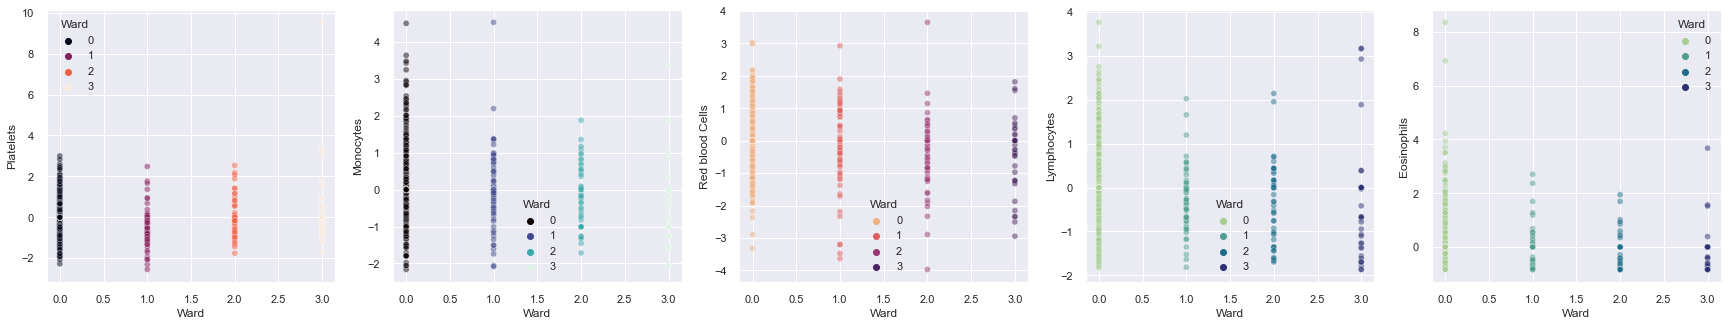

In [133]:
fig, ax = plt.subplots(ncols =5, figsize = (30, 5))

sns.scatterplot(data = covid_final, x = 'Ward', y = 'Platelets', hue = "Ward", alpha=0.5, ax= ax[0], palette="rocket")
sns.scatterplot(data = covid_final, x = 'Ward', y = 'Monocytes', hue = "Ward", alpha=0.5, ax= ax[1], palette="mako")
sns.scatterplot(data = covid_final, x = 'Ward', y = 'Red blood Cells', hue = "Ward", alpha=0.5, ax= ax[2], palette="flare")
sns.scatterplot(data = covid_final, x = 'Ward', y = 'Lymphocytes', hue = "Ward", alpha=0.5, ax= ax[3], palette="crest")
sns.scatterplot(data = covid_final, x = 'Ward', y = 'Eosinophils', hue = "Ward", alpha=0.5, ax= ax[4], palette="crest")


**Observation:** We observed the abnormal distance from the graph to check for the outliers. Turn out that it should not affect the final prediction since it is not many to begin with for all the graph

# 4. Processed Datasets EDA

**4.1 Data correlation**

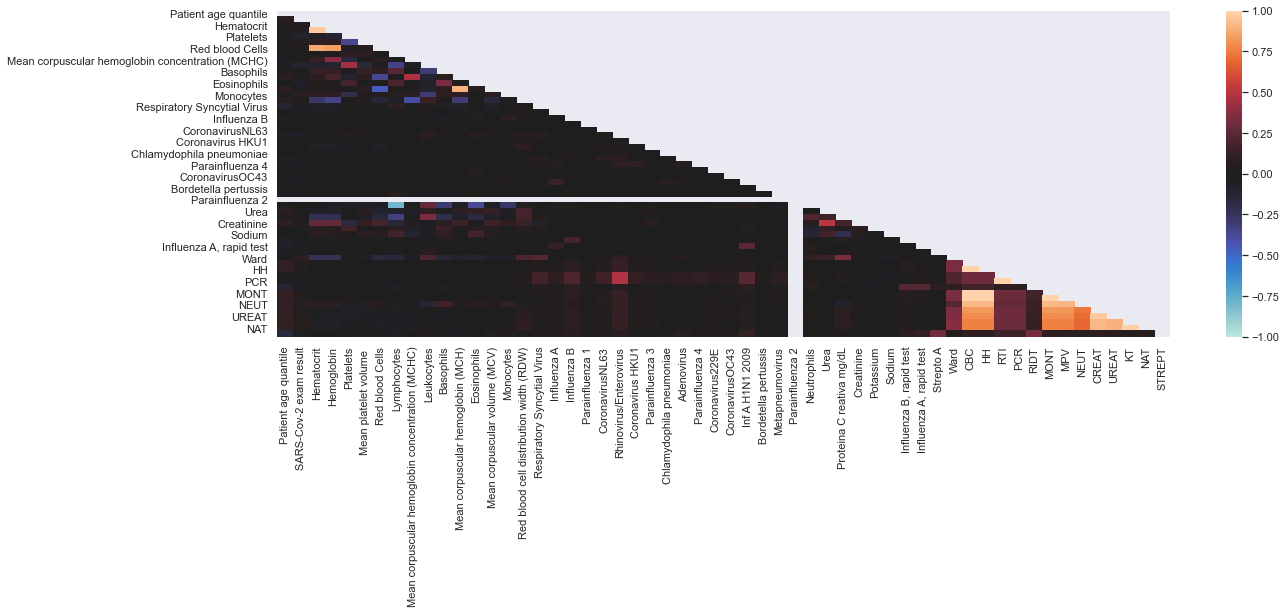

In [43]:
# checking correlation using heatmap
plt.figure(figsize=(20, 6))
#ploting the heatmap for correlation
matrix = np.triu(covid_final.corr())
ax = sns.heatmap(covid_final.corr(), vmin=-1, vmax=1, center= 0, mask=matrix)


**Observation :** The Parainfluenza 2 has no results because both not detected and missing datas are being updated with 'Zero'.

In [44]:
covid_corr=covid_final.corr()
cor_target = abs(covid_corr['Ward'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
# relevant_list=relevant_features.index.tolist()
cor_target.sort_values(ascending=False).head(20)

Ward                                      1.00
NAT                                       0.37
KT                                        0.37
CREAT                                     0.35
UREAT                                     0.35
Proteina C reativa mg/dL                  0.34
MONT                                      0.34
CBC                                       0.34
HH                                        0.34
MPV                                       0.34
NEUT                                      0.23
Hematocrit                                0.23
Respiratory Syncytial Virus               0.23
Hemoglobin                                0.23
Leukocytes                                0.21
PCR                                       0.21
RTI                                       0.21
Red blood cell distribution width (RDW)   0.20
Red blood Cells                           0.16
Lymphocytes                               0.15
Name: Ward, dtype: float64

**Observation :** Proteina C reativa mg/dL,Hematocrit,Respiratory Syncytial Virus,Hemoglobin and Leukocytes results are highly correlated with the wards.

**4.2 Checking Dataset Distribution**

In [45]:
# summarize distribution

target=covid_final['Ward']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))

Ward = 0, n = 5474, Percentage = 96.988%
Ward = 2, n = 50, Percentage = 0.886%
Ward = 1, n = 79, Percentage = 1.400%
Ward = 3, n = 41, Percentage = 0.726%


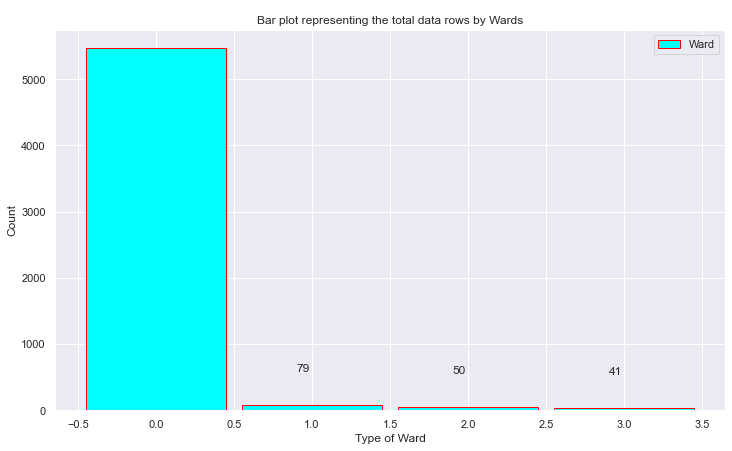

In [46]:
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize = (12,7))
# plt.rcParams["figure.figsize"] = (20,8)

# Passing the parameters to the bar function, this is the main function which creates the bar plot
plt.bar(counter.keys(), counter.values(), width= 0.9, align='center',color='cyan', edgecolor = 'red')

# This is the location for the annotated text
i = 1.0
j = 500

# Annotating the bar plot with the values (total Ward count)
for i in range(len(counter.keys())):
    plt.annotate(counter[i], (-0.1 + i, counter[i] + j))
    
# Creating the legend of the bars in the plot
plt.legend(labels = ['Ward'])    


# Giving the tilte for the plot
plt.title("Bar plot representing the total data rows by Wards")

# Namimg the x and y axis
plt.xlabel('Type of Ward')
plt.ylabel('Count')

# Saving the plot as a 'png'
plt.savefig('Imbalanced Data Plot.png')

# Displaying the bar plot
plt.show()



**Legend**

Ward | Description
:-:|:-
0 | No Ward
1 | Regular Ward
2 | Semi-Intensive Ward
3 | Intensive Care Ward

**Observation :** It is confirmed that the dataset is very imbalanced. With **96.88%** of the rows for **Ward '0'**,**1.4%** for **Ward '1'** and **less than 1%** of the rows for **Ward '2'** and **Ward '3'**.
Insights: 

Patient admitted to regular ward = 79 
43 are Covid (+), 36 are Covid (-)  

Patient admitted to Semi-Intensive Unit = 50
8 are Covid (+), 42 are Covid (-)

Patient admitted to Intensive Care Unit = 41
7 are Covid (+), 34 are Covid (-) 

Not all ICU warded patient are Covid (+), can be due to other diseases.


**4.3 Splitting data**

In [47]:
X = covid_final.drop(['Ward'], axis = 1)
y = covid_final['Ward']

In [48]:
#Stratifying Method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22,stratify=covid_final['Ward'])


In [49]:
#Synthetic Minority Oversampling (Smote) Technique
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, y_train)

print("====================   y_train_smote   ==========================") 

#Checking of data distribution
counter = Counter(Y_train_smote)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))
    
print("====================       y_test      ==========================") 
    
#Checking of data distribution
counter = Counter(y_test )
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))    
    

    
#Synthetic Minority Oversampling (Smote + Split) Technique
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X, y)


print("====================    y_smote    ==========================") 
#Checking of data distribution
counter = Counter(Y_smote)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, Y_smote, test_size = 0.2, random_state = 22)

print("==================== y_smote_train ==========================")    
#Checking of data distribution
counter = Counter(y_smote_train)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))
print("====================  y_smote_test ==========================")    
#Checking of data distribution
counter = Counter(y_smote_test)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))        

====================   y_train_smote   ==========================
Ward = 0, n = 4379, Percentage = 77.587%
Ward = 2, n = 4379, Percentage = 77.587%
Ward = 1, n = 4379, Percentage = 77.587%
Ward = 3, n = 4379, Percentage = 77.587%
====================       y_test      ==========================
Ward = 0, n = 1095, Percentage = 19.401%
Ward = 2, n = 10, Percentage = 0.177%
Ward = 3, n = 8, Percentage = 0.142%
Ward = 1, n = 16, Percentage = 0.283%
====================    y_smote    ==========================
Ward = 0, n = 5474, Percentage = 96.988%
Ward = 2, n = 5474, Percentage = 96.988%
Ward = 1, n = 5474, Percentage = 96.988%
Ward = 3, n = 5474, Percentage = 96.988%
==================== y_smote_train ==========================
Ward = 2, n = 4380, Percentage = 77.605%
Ward = 3, n = 4408, Percentage = 78.101%
Ward = 0, n = 4345, Percentage = 76.984%
Ward = 1, n = 4383, Percentage = 77.658%
====================  y_smote_test ==========================
Ward = 3, n = 1066, Percentage = 18.

**Observation :** (Stratify + Smote Train X,Y) method,produces a less balanced X test and y test data distribution. 

            (Smote X,Y + Split) method,produces a more evenly distributed split train and test dataset.

**4.4 What are patients allocation size in different wards?**

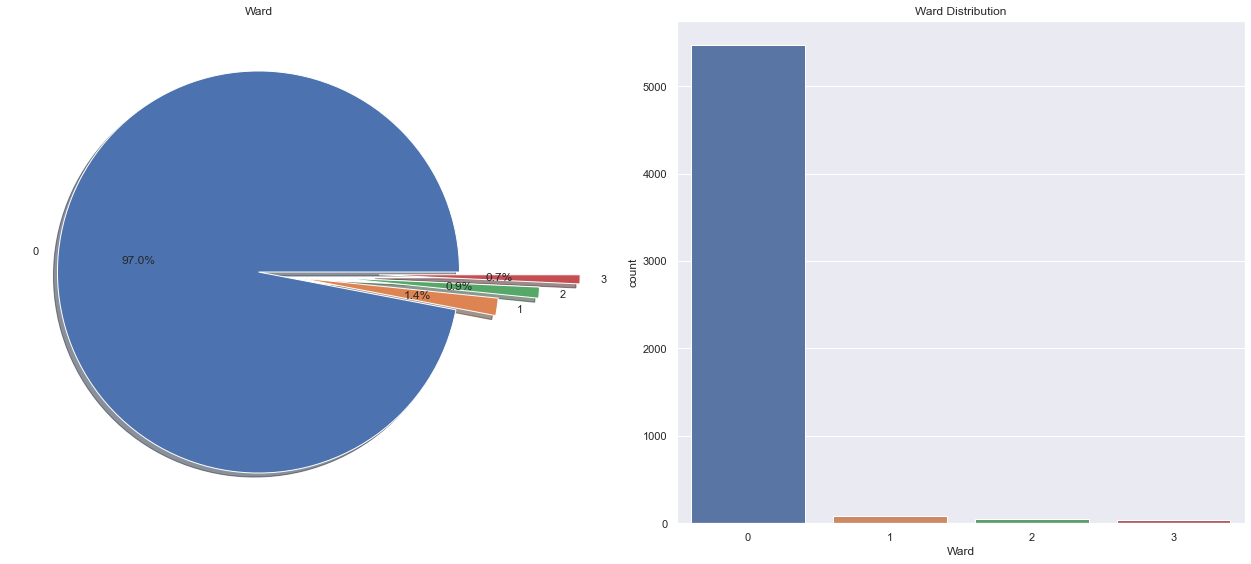

In [50]:
f,ax=plt.subplots(1,2,figsize=(18,8))
covid_new['Ward'].value_counts().plot.pie(explode=[0,0.2,0.4,0.6],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Ward')
ax[0].set_ylabel('')
sns.countplot('Ward',data=covid_new,ax=ax[1])
ax[1].set_title('Ward Distribution')
sns.set(font_scale=1.5)
#Spread out the plots layout
plt.tight_layout()

# Saving the plot as a 'png'
plt.savefig('Wards distribution.png')

#Print the plot
plt.show()

**Observation :** 97% of the patients are not warded, 1.4% are assigned to regular ward,0.9% are assigned to semi-intensive wards and the remaining 0.7% are assigned to intensive care unit. 

**4.5 Does all patients with Positive SARS-Cov-2 Exam Results being assigned with a ward?**

<Figure size 1451.52x1249.92 with 0 Axes>

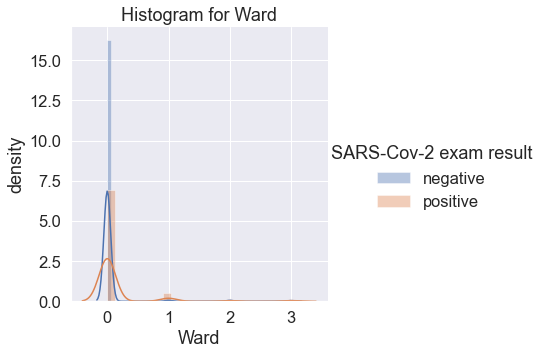

In [51]:
# Create a function for PDF analysis
def histoPDF(featureVar, classVar):
    sns.FacetGrid(data = covid_new, hue = classVar, height = 5) \
    .map(sns.distplot, featureVar) \
    .add_legend(); 
    plt.title("Histogram for " + featureVar)
    plt.ylabel("density")
#     plt.plot('histogram_2.png')
# PDF histogram for age v. status
plt.savefig('Wards VS Covid.png')
histoPDF('Ward','SARS-Cov-2 exam result')

**Observation :** 

1. Overlapping is observed in Ward 0 and 1, which suggests that SARs-Cov-2 exam results might not be a determining factor in the wards assignment.
2. Density of the results are barely observable due to the big different in the number of data for each wards. Another statistical method maybe used to analyse Ward 1,2 and 3 better.

<Figure size 1451.52x1249.92 with 0 Axes>

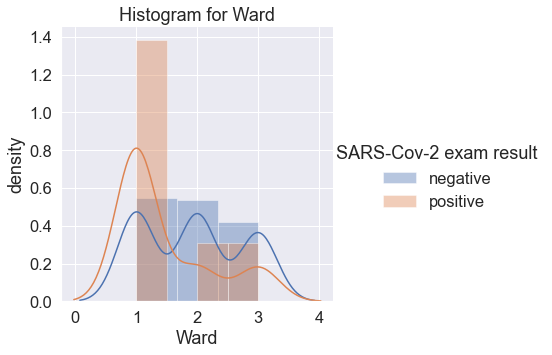

In [52]:
#Exclude Patients that are not warded
Ward123=covid_new.loc[covid_new['Ward']!=0]
# Create a function for PDF analysis
def histoPDF(featureVar, classVar):
    sns.FacetGrid(data = Ward123, hue = classVar, height = 5) \
    .map(sns.distplot, featureVar) \
    .add_legend(); 
    plt.title("Histogram for " + featureVar)
    plt.ylabel("density")
#     plt.plot('histogram_2.png')
# PDF histogram for age v. status
plt.savefig('Wards VS Covid2.png')
histoPDF('Ward','SARS-Cov-2 exam result')

**Model Insight :**

Most of the patients with positive SARS-Cov-2 exam result, are being placed in the regular ward and it suggest that majority of the patients does not have life threatening symptoms.

**4.6 Which age quantile group has the number of patients warded?**

<AxesSubplot:xlabel='Patient age quantile', ylabel='count'>

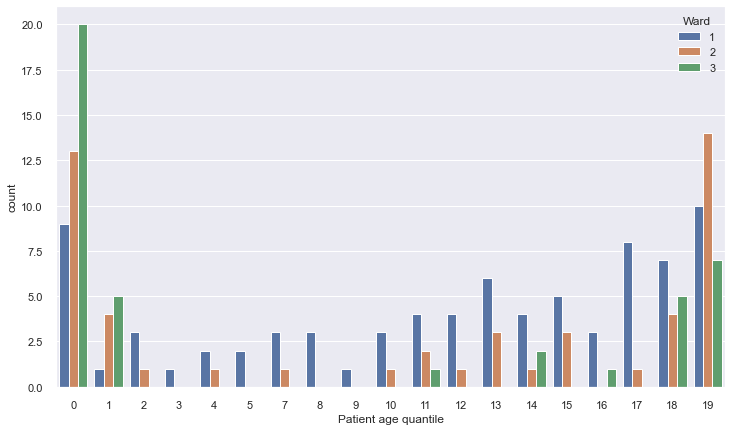

In [134]:
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize = (12,7))
sns.countplot(x='Patient age quantile',hue='Ward',data=covid_new.loc[covid_new['Ward']!=0])

# 5. Classification Models

**5.1 Lazy Predict Classification**

Use lazy predict to find the balanced accuracy for the 2 datasets that were derived using 2 techniques

In [53]:
LC = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = LC.fit(X_train_smote, X_test, Y_train_smote, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [02:51<00:00,  5.92s/it]


In [54]:
LC2 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models2,predictions = LC2.fit(X_smote_train, X_smote_test, y_smote_train, y_smote_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [03:16<00:00,  6.76s/it]


In [55]:
print("====Lazy Predict with dataset split using stratify technique and smote train dataset====")
display(models.head())
print("=============================Lazy Predict with smote dataset=============================")
models2.head()

====Lazy Predict with dataset split using stratify technique and smote train dataset====


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RidgeClassifierCV,0.85,0.56,None,0.90,0.14
RidgeClassifier,0.85,0.56,None,0.90,0.08
XGBClassifier,0.92,0.53,None,0.94,10.31
LogisticRegression,0.84,0.52,None,0.90,0.77
LinearSVC,0.85,0.52,None,0.90,13.29


=============================Lazy Predict with smote dataset=============================


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.93,0.93,None,0.93,12.94
LGBMClassifier,0.93,0.93,None,0.93,2.62
RandomForestClassifier,0.93,0.93,None,0.93,2.88
ExtraTreesClassifier,0.93,0.93,None,0.93,1.42
BaggingClassifier,0.92,0.92,None,0.92,1.64


**Observation :** Lazy predict that uses the smote dataset churn a better balanced Accuracy. In multiclass classification, balanced accuracy is important when we are dealing with imbalanced datasets. It is defined as the average of recall obtained on each class. 

As lazy predict using the smote dataset have a higher balanced acurracy, so we will do a comparison for the **3** models that was randomly picked from the top 4 models,to find out which model is able to provide us with a better prediction.

**ROC AUC is None because this is a multi-classification dataset, and we can use roc_auc_score rather than ROC AUC**

**5.2 Define Function for evaluation metrics**

In [56]:
#Define Confusion Matrix Function(Annot Percentage and count)
def plot_cm(y_test, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax,
                yticklabels = ['Not Warded', 'Regular Ward','Semi-Intensive','Intensive Care Unit'], 
                xticklabels = ['Not Warded', 'Regular Ward','Semi-Intensive','Intensive Care Unit'])
    plt.show()
 

In [57]:
#Define roc_auc_score for each ward
def roc_auc_score_multiclass(y_test, y_pred, average = "macro"):
    
    #creating a set of all the unique wards using the actual class list
    unique_ward = set(y_test)
    roc_auc_dict = {}
    for per_ward in unique_ward:
        
        #creating a list of all the wards except the current ward 
        other_ward = [x for x in unique_ward if x != per_ward]

        #marking the current ward as 1 and all other wards as 0
        new_y_test = [0 if x in other_ward else 1 for x in y_test]
        new_y_pred = [0 if x in other_ward else 1 for x in y_pred]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_y_test, new_y_pred, average = average)
        roc_auc_dict[per_ward] = roc_auc

    return roc_auc_dict

**5.3 XGBClassifier**

In [58]:
%%time
#Train model 
# define the model for multi-class classification
# “multi:softprob“: XGBoost loss function for multi-class classification.
# "mlogloss": Multiclass logloss.
xgb = XGBClassifier( objective = 'multi:softprob')
#Fit Model
xgb.fit(X_train_smote, Y_train_smote)

#Generate predictions with the model using our X values
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)

#GPrint Evaluation Metrix
print(classification_report(y_test, y_pred))
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_test, y_pred))
#roc auc score for each ward
roc_auc=roc_auc_score_multiclass(y_test, y_pred)
roc_auc_=pd.DataFrame.from_dict(roc_auc,orient='index',columns=['Stratify_smote'])

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1095
           1       0.11      0.38      0.16        16
           2       0.25      0.30      0.27        10
           3       0.22      0.50      0.31         8

    accuracy                           0.92      1129
   macro avg       0.39      0.53      0.43      1129
weighted avg       0.96      0.92      0.94      1129

Accuracy : 0.9229406554472985
Balanced Accuracy : 0.5286815068493151
Wall time: 11.3 s


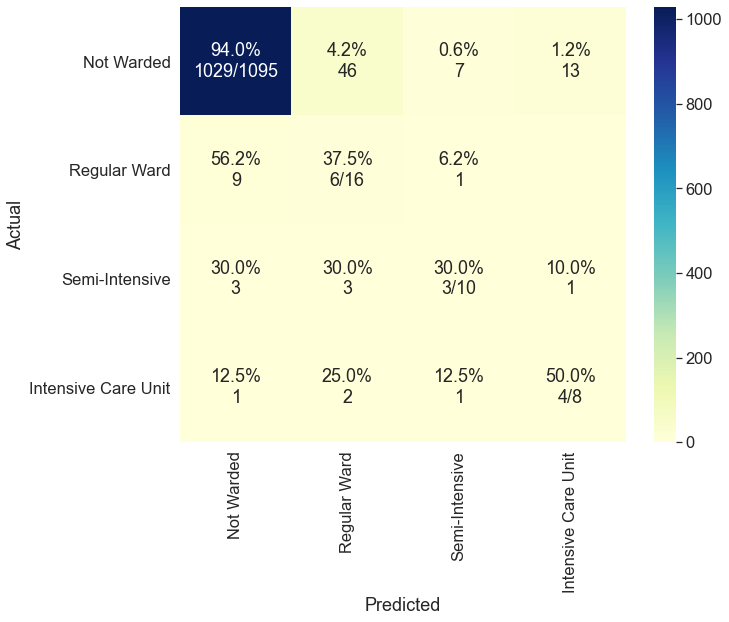

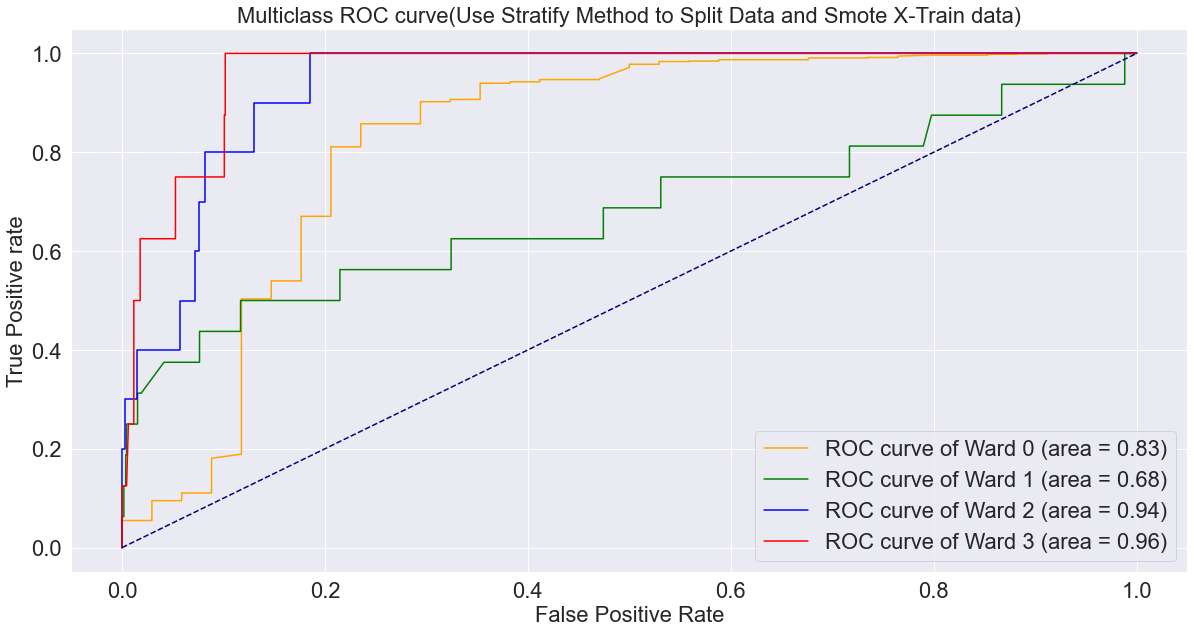

In [59]:
# Visualize confusion matrix
plot_cm(y_test, y_pred)


# Visualizing ROC Curve

fpr = {}
tpr = {}
thresh ={}
roc_auc={}
n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr[0], tpr[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc[0]))
plt.plot(fpr[1], tpr[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc[1]))
plt.plot(fpr[2], tpr[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc[2]))
plt.plot(fpr[3], tpr[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc[3]))

plt.title('Multiclass ROC curve(Use Stratify Method to Split Data and Smote X-Train data)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

**Xgboost after using Smote to balanced the data**

In [60]:
#Train model 
# define the model for multi-class classification
# “multi:softprob“: XGBoost loss function for multi-class classification.
# "mlogloss": Multiclass logloss.
xgb = XGBClassifier( objective = 'multi:softprob')
#Fit Model
xgb.fit(X_smote_train, y_smote_train)
#Generate predictions with the model using our X values
y_smote_pred = xgb.predict(X_smote_test)
y_smote_prob = xgb.predict_proba(X_smote_test)

print(classification_report(y_smote_test, y_smote_pred))
print("Accuracy :",metrics.accuracy_score(y_smote_test, y_smote_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_smote_test, y_smote_pred))
#roc auc score for each ward
smote_roc_auc=roc_auc_score_multiclass(y_smote_test, y_smote_pred)
roc_auc_smote=pd.DataFrame.from_dict(smote_roc_auc,orient='index',columns=['Smote'])

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1129
           1       0.93      0.90      0.91      1091
           2       0.98      0.92      0.95      1094
           3       0.87      0.98      0.93      1066

    accuracy                           0.93      4380
   macro avg       0.93      0.93      0.93      4380
weighted avg       0.93      0.93      0.93      4380

Accuracy : 0.9292237442922374
Balanced Accuracy : 0.9296621526079807


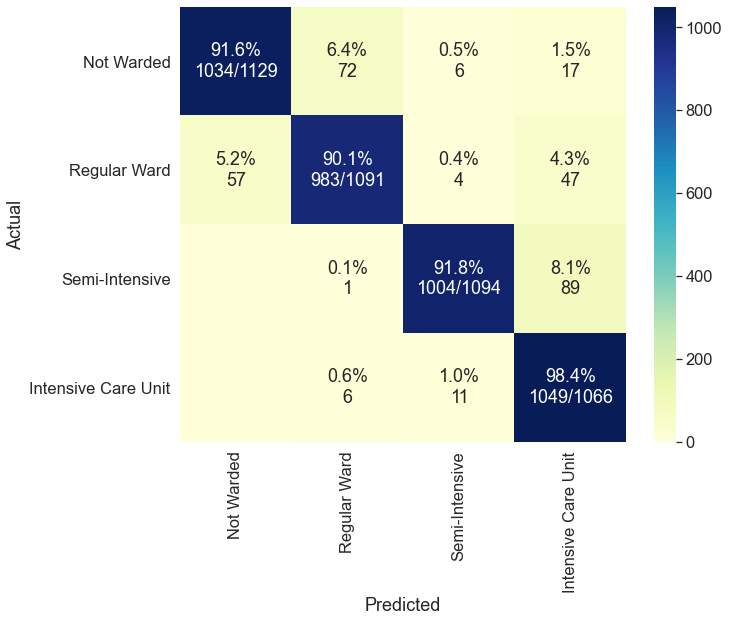

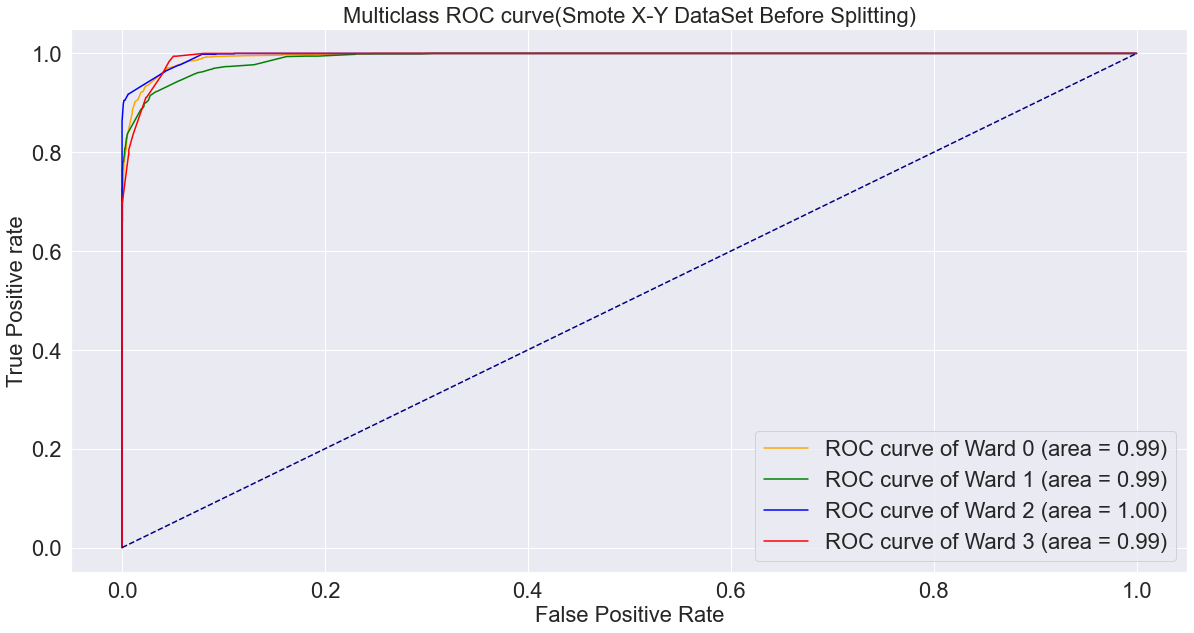

In [61]:
# Visualize confusion matrix
plot_cm(y_smote_test, y_smote_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_smote_test, y_smote_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet Before Splitting)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

**Observation :** After comparing both multiclass ROC curve plots, i have decided to go with smote the whole dataset before splitting to train and test data. Reason being the high roc and auc score for all the different wards. 

# Hyperparameter Tuning for XGBoost Classifier

In [62]:
%%time
#Parameters Grid for XGBoost
space =  {"max_depth" :  list(range(1,20)),
          "n_estimators" : list(range(50,401,25)),
          "objective" : ['multi:softprob'],
          "eval_metric" : ['mlogloss']
                  }

grid_model_xgb = GridSearchCV(XGBClassifier(),space,cv=2, return_train_score=False)

# execute search
result=grid_model_xgb.fit(X_smote_train, y_smote_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Best Score: 0.9238981502626171
Best Hyperparameters: {'eval_metric': 'mlogloss', 'max_depth': 18, 'n_estimators': 400, 'objective': 'multi:softprob'}
Wall time: 2h 20min 59s


In [63]:
%%time
#Train model 
# define the model for multi-class classification
# “multi:softprob“: XGBoost loss function for multi-class classification.
# "mlogloss": Multiclass logloss.
xgb = XGBClassifier( n_estimators=grid_model_xgb.best_estimator_.get_params()['n_estimators'],
                    max_depth = grid_model_xgb.best_estimator_.get_params()['max_depth'], 
                    objective = 'multi:softprob', eval_metric = 'mlogloss')
#Fit Model
xgb.fit(X_smote_train, y_smote_train)
#Generate predictions with the model using our X values
y_tune_pred = xgb.predict(X_smote_test)
y_tune_prob = xgb.predict_proba(X_smote_test)

print(classification_report(y_smote_test, y_tune_pred))
print("Accuracy :",metrics.accuracy_score(y_smote_test, y_tune_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_smote_test, y_tune_pred))
#roc auc score for each ward
tune_roc_auc=roc_auc_score_multiclass(y_smote_test, y_tune_pred)
roc_auc_tune=pd.DataFrame.from_dict(tune_roc_auc,orient='index',columns=['After Tune'])

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1129
           1       0.92      0.90      0.91      1091
           2       0.98      0.92      0.95      1094
           3       0.87      0.98      0.92      1066

    accuracy                           0.93      4380
   macro avg       0.93      0.93      0.93      4380
weighted avg       0.93      0.93      0.93      4380

Accuracy : 0.9292237442922374
Balanced Accuracy : 0.9296621526079807
Wall time: 57.6 s


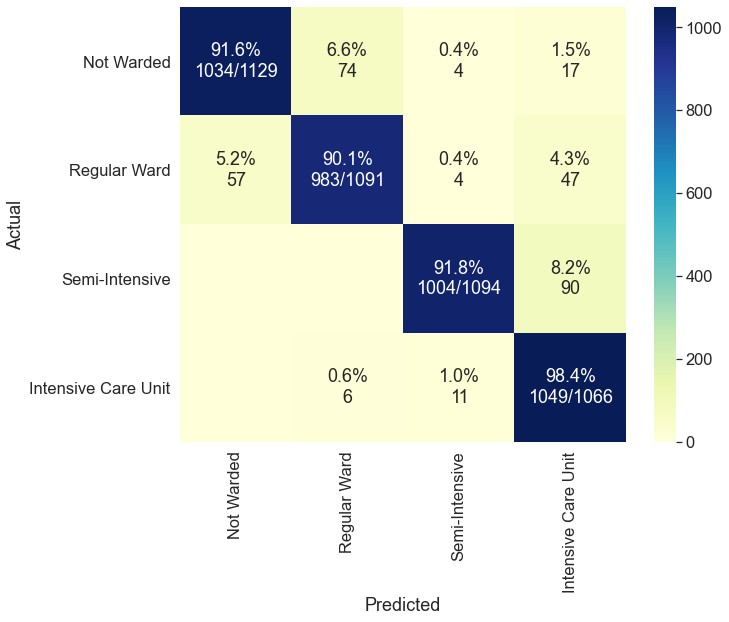

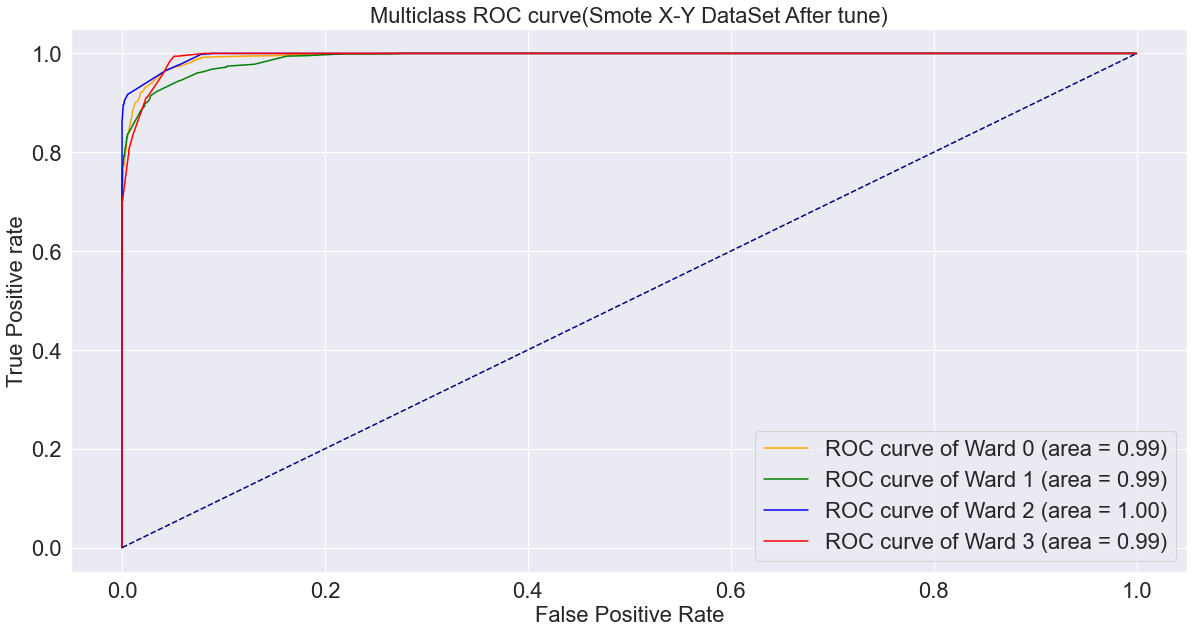

In [64]:
# Visualize confusion matrix
plot_cm(y_smote_test, y_tune_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_smote_test, y_tune_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet After tune)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

In [65]:
%%time 
#Comparison Table
x1 = PrettyTable()
x1.title = 'Results for Xgboost'
x1.field_names = ["Evaluation Metrics","Stratify + Smote", "Smote", "After Tune"]
x1.add_row(["Balanced Accuracy", round(metrics.balanced_accuracy_score(y_test, y_pred),3),round(metrics.balanced_accuracy_score(y_smote_test, y_smote_pred),3), round(metrics.balanced_accuracy_score(y_smote_test, y_tune_pred),3)])
x1.add_row(["Macro-averaged f1 score", round(metrics.f1_score(y_test, y_pred, average = 'macro'),3),round(metrics.f1_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.f1_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x1.add_row(["Micro-averaged f1 score", round(metrics.f1_score(y_test, y_pred, average = 'micro'),3),round(metrics.f1_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.f1_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
x1.add_row(["Macro-averaged precision score", round(metrics.precision_score(y_test, y_pred, average = 'macro'),3),round(metrics.precision_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.precision_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x1.add_row(["Micro-averaged precision score", round(metrics.precision_score(y_test, y_pred, average = 'micro'),3),round(metrics.precision_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.precision_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
x1.add_row(["Macro-averaged recall score", round(metrics.recall_score(y_test, y_pred, average = 'macro'),3),round(metrics.recall_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.recall_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x1.add_row(["Micro-averaged recall score", round(metrics.recall_score(y_test, y_pred, average = 'micro'),3),round(metrics.recall_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.recall_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
print (x1)

roc_auc_.join(roc_auc_smote).join(roc_auc_tune)



+------------------------------------------------------------------------+
|                          Results for Xgboost                           |
+--------------------------------+------------------+-------+------------+
|       Evaluation Metrics       | Stratify + Smote | Smote | After Tune |
+--------------------------------+------------------+-------+------------+
|       Balanced Accuracy        |      0.529       |  0.93 |    0.93    |
|    Macro-averaged f1 score     |      0.427       | 0.929 |   0.929    |
|    Micro-averaged f1 score     |      0.923       | 0.929 |   0.929    |
| Macro-averaged precision score |      0.391       | 0.931 |   0.931    |
| Micro-averaged precision score |      0.923       | 0.929 |   0.929    |
|  Macro-averaged recall score   |      0.529       |  0.93 |    0.93    |
|  Micro-averaged recall score   |      0.923       | 0.929 |   0.929    |
+--------------------------------+------------------+-------+------------+
Wall time: 46.2 ms


,Stratify_smote,Smote,After Tune
0,0.78,0.95,0.95
1,0.66,0.94,0.94
2,0.65,0.96,0.96
3,0.74,0.97,0.97


**Observation :** 

**Dataset Splitting Method**
Smote whole dataset before splitting to train and test dataset produces better ROC and AUC Score and improved the accuracy score for all the wards. Therefore the dataset that was split using this method, will be used for the rest of the model training and prediction.

**Model Comparison**
No improvement is observed, despite the fact that different parameters are used.

**5.4 Extra Trees Classifier**

In [66]:
etc=ExtraTreesClassifier()

etc.fit(X_smote_train, y_smote_train)

y_smote_pred = etc.predict(X_smote_test)
y_smote_prob = etc.predict_proba(X_smote_test)

print(classification_report(y_smote_test, y_smote_pred))
print("Accuracy :",metrics.accuracy_score(y_smote_test, y_smote_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_smote_test, y_smote_pred))
#roc auc score for each ward
smote_roc_auc=roc_auc_score_multiclass(y_smote_test, y_smote_pred)
roc_auc_smote=pd.DataFrame.from_dict(smote_roc_auc,orient='index',columns=['Smote'])

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1129
           1       0.92      0.90      0.91      1091
           2       0.98      0.92      0.95      1094
           3       0.87      0.98      0.92      1066

    accuracy                           0.93      4380
   macro avg       0.93      0.93      0.93      4380
weighted avg       0.93      0.93      0.93      4380

Accuracy : 0.9257990867579908
Balanced Accuracy : 0.9262979485173


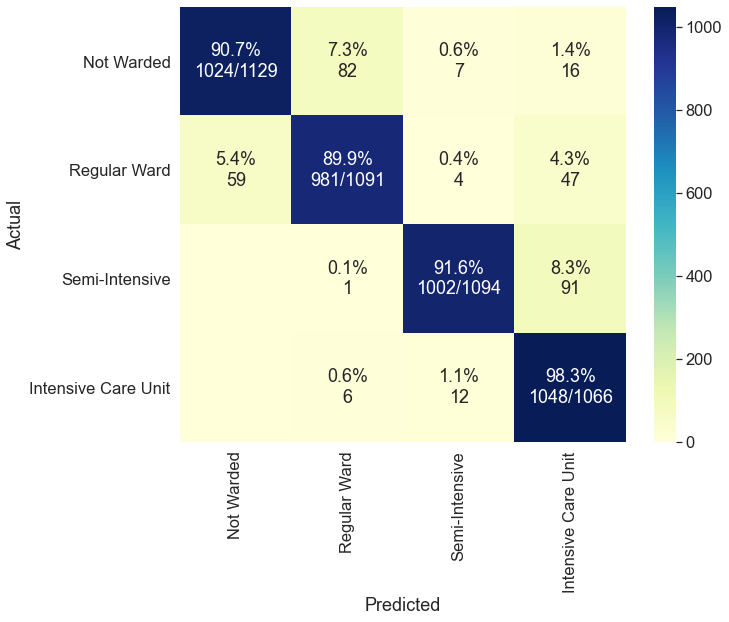

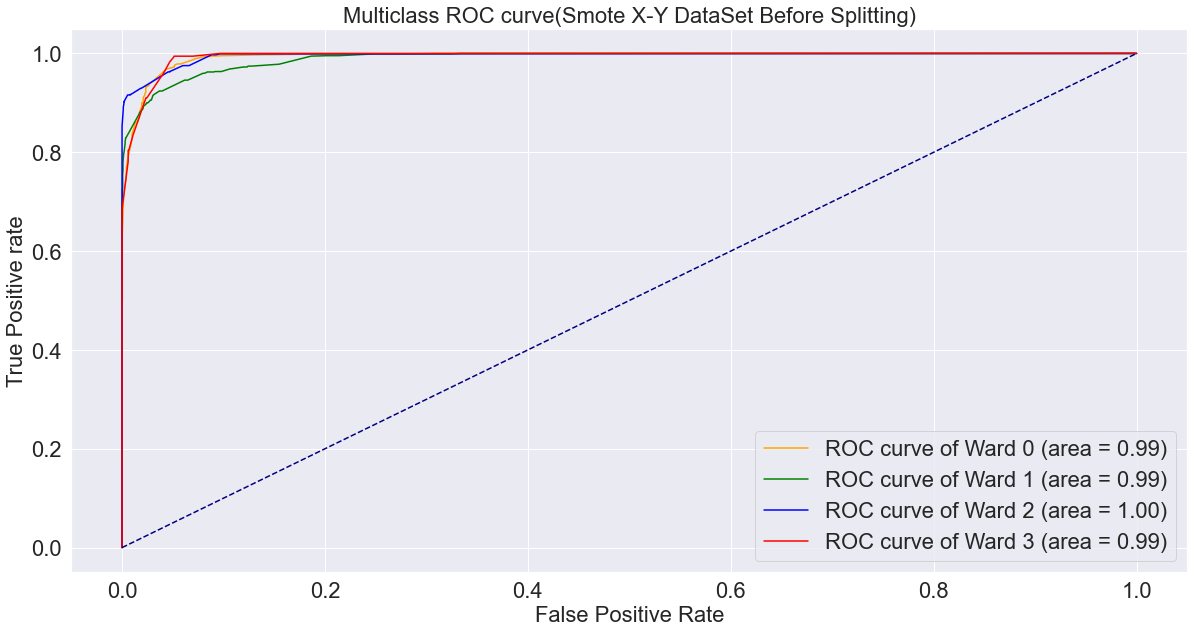

In [67]:
# Visualize confusion matrix
plot_cm(y_smote_test, y_smote_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_smote_test, y_smote_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet Before Splitting)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

# Hyperparameter Tuning for Extra Trees Classifier

In [68]:
%%time
#Parameter for Extra Trees Classifier
space =  {"criterion"    : ['entropy','gini'] ,
         "n_estimators"  : list(range(50,401,25)),
          "min_samples_split"  :  list(range(1,20))}

grid_model_etc = GridSearchCV(ExtraTreesClassifier(),space)

# execute search
result=grid_model_etc.fit(X_smote_train, y_smote_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9240695841920232
Best Hyperparameters: {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 375}
Wall time: 2h 51min 51s


In [69]:
%%time
#Train model 
# define the model for multi-class classification
# “multi:softprob“: XGBoost loss function for multi-class classification.
# "mlogloss": Multiclass logloss.


etc=ExtraTreesClassifier(criterion=grid_model_etc.best_estimator_.get_params()['criterion'],
                         n_estimators=grid_model_etc.best_estimator_.get_params()['n_estimators'],
                         min_samples_split=grid_model_etc.best_estimator_.get_params()['min_samples_split'])

#Fit Model
etc.fit(X_smote_train, y_smote_train)
#Generate predictions with the model using our X values
y_tune_pred = etc.predict(X_smote_test)
y_tune_prob = etc.predict_proba(X_smote_test)

print(classification_report(y_smote_test, y_tune_pred))
print("Accuracy :",metrics.accuracy_score(y_smote_test, y_tune_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_smote_test, y_tune_pred))
#roc auc score for each ward
tune_roc_auc=roc_auc_score_multiclass(y_smote_test, y_tune_pred)
roc_auc_tune=pd.DataFrame.from_dict(tune_roc_auc,orient='index',columns=['After Tune'])

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1129
           1       0.92      0.90      0.91      1091
           2       0.98      0.92      0.95      1094
           3       0.87      0.98      0.92      1066

    accuracy                           0.93      4380
   macro avg       0.93      0.93      0.93      4380
weighted avg       0.93      0.93      0.93      4380

Accuracy : 0.9262557077625571
Balanced Accuracy : 0.926755615283948
Wall time: 5.6 s


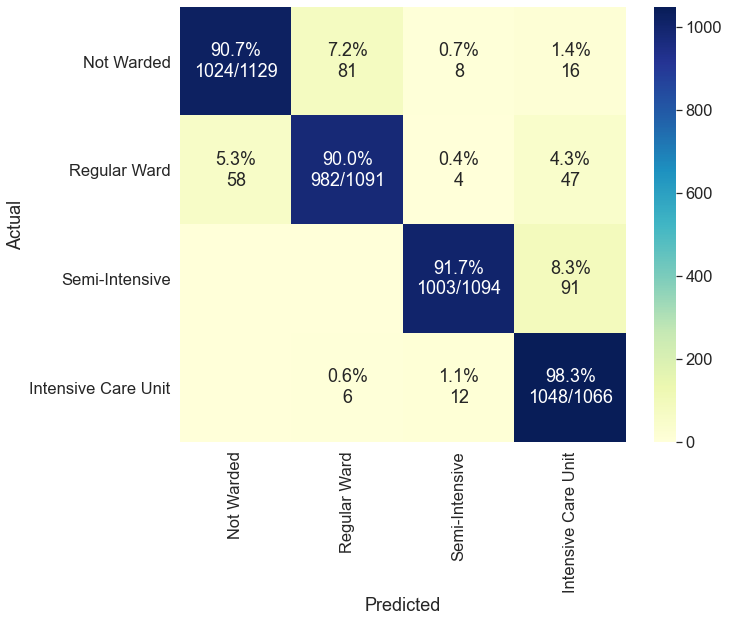

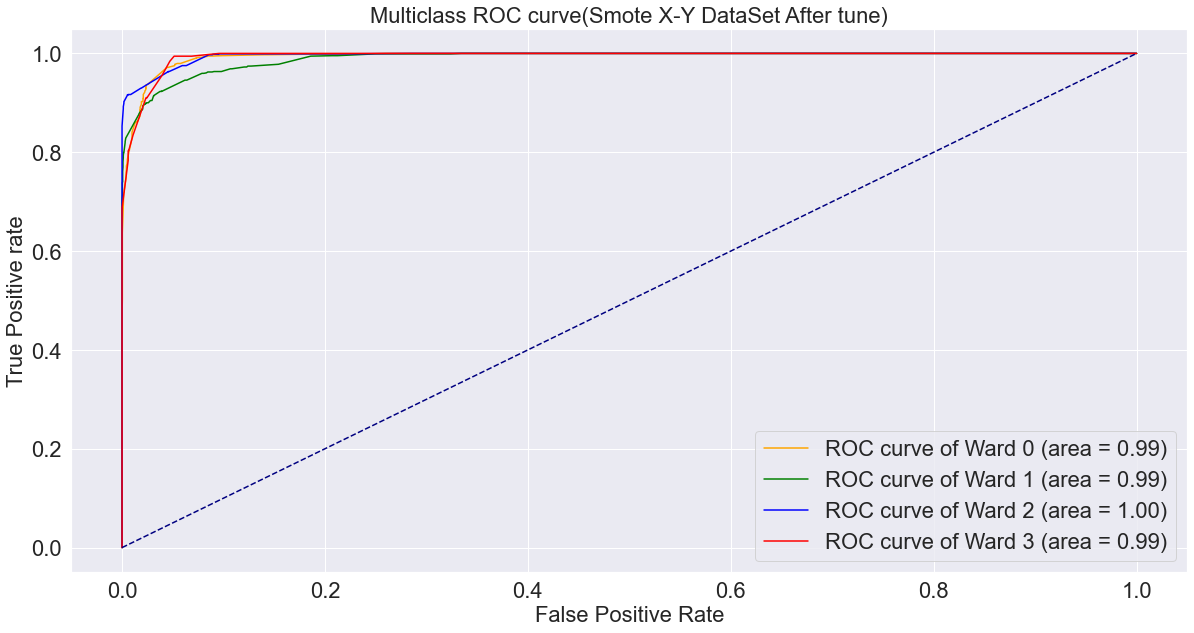

In [70]:
 # Visualize confusion matrix
plot_cm(y_smote_test, y_tune_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_smote_test, y_tune_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet After tune)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

In [71]:
%%time 
#Comparison Table
x2 = PrettyTable()
x2.title = 'Results for Extra Tree Classifier'
x2.field_names = ["Evaluation Metrics", "Smote", "After Tune"]
x2.add_row(["Balanced Accuracy",round(metrics.balanced_accuracy_score(y_smote_test, y_smote_pred),3), round(metrics.balanced_accuracy_score(y_smote_test, y_tune_pred),3)])
x2.add_row(["Macro-averaged f1 score",round(metrics.f1_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.f1_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x2.add_row(["Micro-averaged f1 score",round(metrics.f1_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.f1_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
x2.add_row(["Macro-averaged precision score",round(metrics.precision_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.precision_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x2.add_row(["Micro-averaged precision score",round(metrics.precision_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.precision_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
x2.add_row(["Macro-averaged recall score",round(metrics.recall_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.recall_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x2.add_row(["Micro-averaged recall score",round(metrics.recall_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.recall_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
print (x2)

roc_auc_smote.join(roc_auc_tune)


+-----------------------------------------------------+
|          Results for Extra Tree Classifier          |
+--------------------------------+-------+------------+
|       Evaluation Metrics       | Smote | After Tune |
+--------------------------------+-------+------------+
|       Balanced Accuracy        | 0.926 |   0.927    |
|    Macro-averaged f1 score     | 0.926 |   0.926    |
|    Micro-averaged f1 score     | 0.926 |   0.926    |
| Macro-averaged precision score | 0.928 |   0.928    |
| Micro-averaged precision score | 0.926 |   0.926    |
|  Macro-averaged recall score   | 0.926 |   0.927    |
|  Micro-averaged recall score   | 0.926 |   0.926    |
+--------------------------------+-------+------------+
Wall time: 46.9 ms


,Smote,After Tune
0,0.94,0.94
1,0.94,0.94
2,0.95,0.95
3,0.97,0.97


**Observation :** There is slight improvement in accuracy and balanced accuracy score.

                                            Improvement:
Accuracy | Balanced Accuracy
:-:|:-
+0.000457 | +0.000458

**5.5 Random Forest Classifier**

In [72]:
rfc=RandomForestClassifier(criterion="entropy",max_depth=10,n_estimators=10,max_features="auto")

rfc.fit(X_smote_train, y_smote_train)

y_smote_pred = rfc.predict(X_smote_test)
y_smote_prob = rfc.predict_proba(X_smote_test)

print(classification_report(y_smote_test, y_smote_pred))
print("Accuracy :",metrics.accuracy_score(y_smote_test, y_smote_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_smote_test, y_smote_pred))
#roc auc score for each ward
smote_roc_auc=roc_auc_score_multiclass(y_smote_test, y_smote_pred)
roc_auc_smote=pd.DataFrame.from_dict(smote_roc_auc,orient='index',columns=['Smote'])

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1129
           1       0.91      0.82      0.86      1091
           2       0.96      0.91      0.94      1094
           3       0.87      0.97      0.92      1066

    accuracy                           0.90      4380
   macro avg       0.90      0.90      0.90      4380
weighted avg       0.90      0.90      0.90      4380

Accuracy : 0.9
Balanced Accuracy : 0.9004663978679517


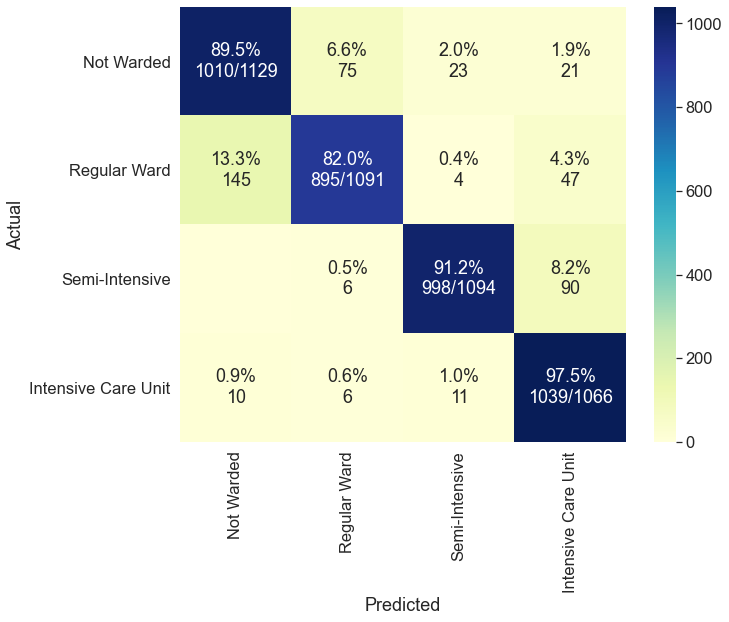

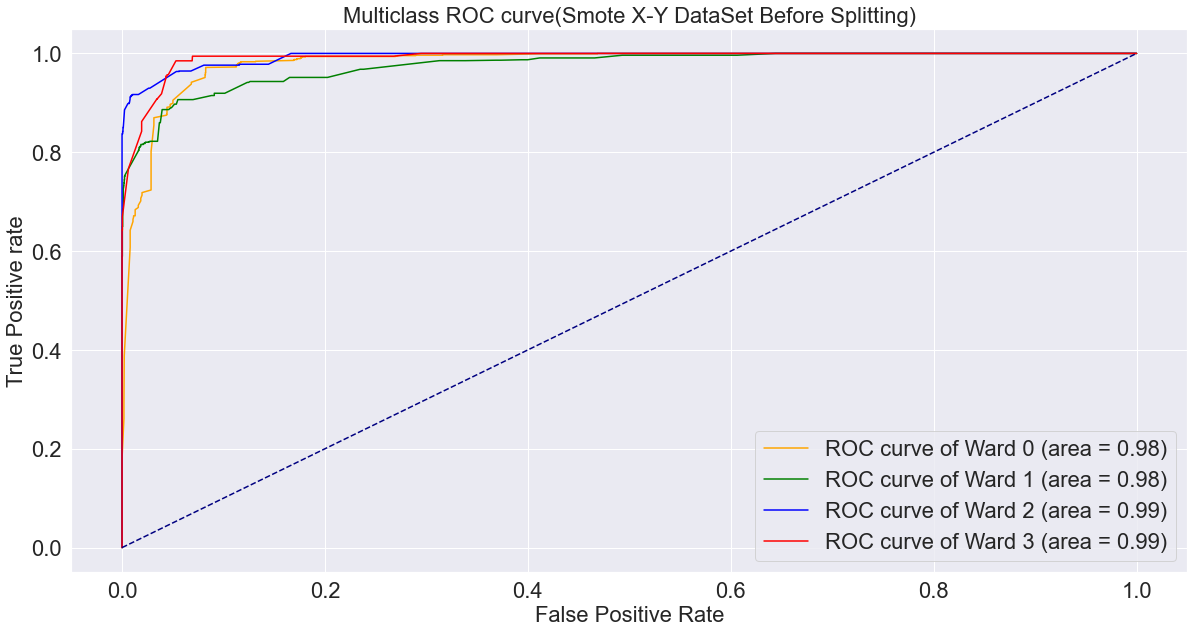

In [73]:
# Visualize confusion matrix
plot_cm(y_smote_test, y_smote_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_smote_test, y_smote_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet Before Splitting)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

# Hyperparameter Tuning Random Forest Classifier

In [74]:
%%time
#Parameter for Random Forest Classifier
space =  {"criterion"    : ['entropy','gini'] ,
         "max_depth"        : list(range(1,15)),
         'max_features': ['auto','sqrt','log2'],
          'n_estimators' :list(range(1,20))}

grid_model_rfc = GridSearchCV(RandomForestClassifier(),space)

# execute search
result=grid_model_rfc.fit(X_smote_train, y_smote_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9215576472612514
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'n_estimators': 15}
Wall time: 27min 14s


In [75]:
%%time
#Train model 
# define the model for multi-class classification
# “multi:softprob“: XGBoost loss function for multi-class classification.
# "mlogloss": Multiclass logloss.


rtc=RandomForestClassifier(criterion=grid_model_rfc.best_estimator_.get_params()['criterion'],
                         max_depth=grid_model_rfc.best_estimator_.get_params()['max_depth'],
                         max_features=grid_model_rfc.best_estimator_.get_params()['max_features'],
                         n_estimators=grid_model_rfc.best_estimator_.get_params()['n_estimators'] )

#Fit Model
rtc.fit(X_smote_train, y_smote_train)
#Generate predictions with the model using our X values
y_tune_pred = rtc.predict(X_smote_test)
y_tune_prob = rtc.predict_proba(X_smote_test)

print(classification_report(y_smote_test, y_tune_pred))
print("Accuracy :",metrics.accuracy_score(y_smote_test, y_tune_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y_smote_test, y_tune_pred))
#roc auc score for each ward
tune_roc_auc=roc_auc_score_multiclass(y_smote_test, y_tune_pred)
roc_auc_tune=pd.DataFrame.from_dict(tune_roc_auc,orient='index',columns=['After Tune'])

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1129
           1       0.92      0.89      0.90      1091
           2       0.97      0.92      0.94      1094
           3       0.87      0.98      0.93      1066

    accuracy                           0.92      4380
   macro avg       0.92      0.92      0.92      4380
weighted avg       0.92      0.92      0.92      4380

Accuracy : 0.9223744292237442
Balanced Accuracy : 0.9229188409161369
Wall time: 1.2 s


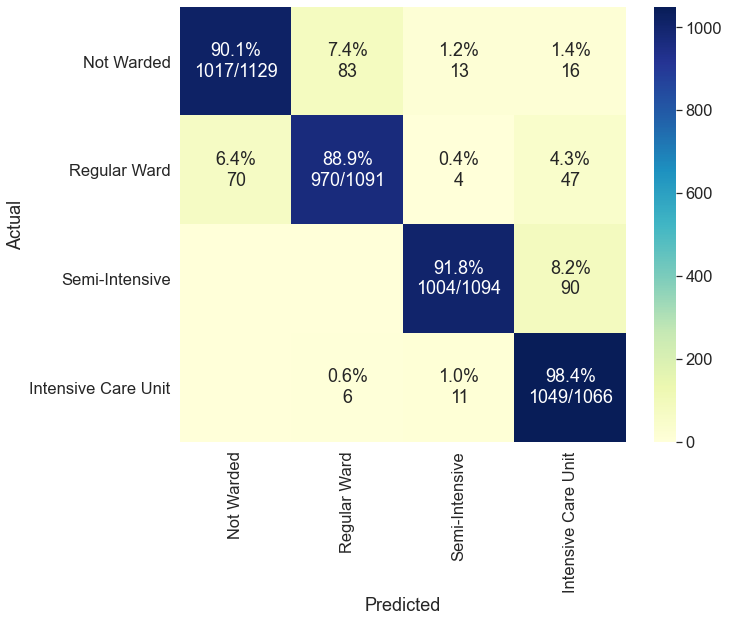

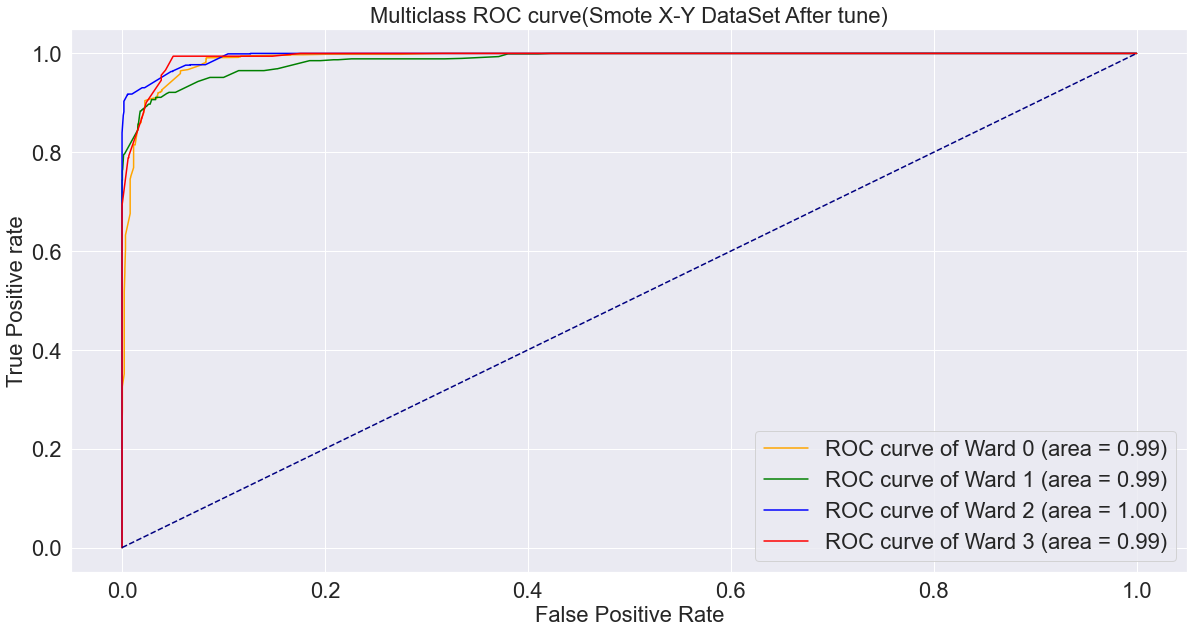

In [76]:
 # Visualize confusion matrix
plot_cm(y_smote_test, y_tune_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_smote_test, y_tune_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet After tune)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

In [77]:
%%time 
#Comparison Table
x3 = PrettyTable()
x3.title = 'Results for Random Forest Classifier'
x3.field_names = ["Evaluation Metrics", "Smote", "After Tune"]
x3.add_row(["Balanced Accuracy",round(metrics.balanced_accuracy_score(y_smote_test, y_smote_pred),3), round(metrics.balanced_accuracy_score(y_smote_test, y_tune_pred),3)])
x3.add_row(["Macro-averaged f1 score",round(metrics.f1_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.f1_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x3.add_row(["Micro-averaged f1 score",round(metrics.f1_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.f1_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
x3.add_row(["Macro-averaged precision score",round(metrics.precision_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.precision_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x3.add_row(["Micro-averaged precision score",round(metrics.precision_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.precision_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
x3.add_row(["Macro-averaged recall score",round(metrics.recall_score(y_smote_test, y_smote_pred, average = 'macro'),3), round(metrics.recall_score(y_smote_test, y_tune_pred, average = 'macro'),3)])
x3.add_row(["Micro-averaged recall score",round(metrics.recall_score(y_smote_test, y_smote_pred, average = 'micro'),3), round(metrics.recall_score(y_smote_test, y_tune_pred, average = 'micro'),3)])
print (x3)

roc_auc_smote.join(roc_auc_tune)


+-----------------------------------------------------+
|         Results for Random Forest Classifier        |
+--------------------------------+-------+------------+
|       Evaluation Metrics       | Smote | After Tune |
+--------------------------------+-------+------------+
|       Balanced Accuracy        |  0.9  |   0.923    |
|    Macro-averaged f1 score     |  0.9  |   0.922    |
|    Micro-averaged f1 score     |  0.9  |   0.922    |
| Macro-averaged precision score | 0.902 |   0.924    |
| Micro-averaged precision score |  0.9  |   0.922    |
|  Macro-averaged recall score   |  0.9  |   0.923    |
|  Micro-averaged recall score   |  0.9  |   0.922    |
+--------------------------------+-------+------------+
Wall time: 42.9 ms


,Smote,After Tune
0,0.92,0.94
1,0.90,0.93
2,0.95,0.95
3,0.96,0.97


**Observation :** All the scores have shown significant improvement.

                                            Improvement:
Accuracy | Balanced Accuracy
:-:|:-
+0.022374 | +0.022452

**5.6 Max Voting Method**

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

The max voting method is generally used for classification problems. In this technique, multiple models are used to make predictions for each data point. The predictions by each model are considered as a ‘vote’. The predictions which we get from the majority of the models are used as the final prediction.

In [78]:
# create the sub models
estimators = []

XGboost_Model = xgb
estimators.append(('XGboost', XGboost_Model))

RandomForest_Model = rfc
estimators.append(('RandomForest', RandomForest_Model))

ExtraTrees_Model = etc
estimators.append(('ExtraTrees', ExtraTrees_Model))

#Execute loop
for i in (XGboost_Model, RandomForest_Model, ExtraTrees_Model):
    
     # train each individual model
    i.fit(X_smote_train, y_smote_train)
    
    # predict on test set
    Y_pred = i.predict(X_smote_test)
    
    # print accuracy results
    print(i, classification_report(y_smote_test, Y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=18, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)               precision    recall  f1-score   support

           0       0.95      0.92      0.93      1129
           1       0.92      0.90      0.91      1091
           2       0.98      0.92      0.95      1094
           3       0.87      0.98      0.92      1066

    accuracy                           0.93      4380
   macro avg       0.9

In [80]:
#Define model
model1 = xgb
model2 = rtc
model3 = etc

model4 = VotingClassifier(estimators=[('xgb', model1), ('rtc', model2), ('etc', model3)], voting='hard')


for model, label in zip([model1, model2, model3, model4], ['XGBoost', 'Random Forest', 'Extra Trees', 'Ensemble']):
    results, names = list(), list()
    scores = cross_val_score(model, X_smote, Y_smote, scoring='accuracy', cv=5)
    results.append(scores)
    names.append(label)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))


results

Accuracy: 0.927 (+/- 0.008) [XGBoost]
Accuracy: 0.920 (+/- 0.008) [Random Forest]
Accuracy: 0.924 (+/- 0.009) [Extra Trees]
Accuracy: 0.926 (+/- 0.009) [Ensemble]


[array([0.92077626, 0.92623887, 0.94039735, 0.92760904, 0.91436401])]

**Observation :**  XGBoost produce the best results for it has higher accuracy score ,macro average and weighted average. 
The score for the individual wards are also higher than the random forest classifier and extra trees classifer model. 

**5.7 Feature importance**

In [116]:
%%time


col_sorted_by_importance=xgb.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'Features':X.columns[col_sorted_by_importance],
    'Importance':xgb.feature_importances_[col_sorted_by_importance]*100.0
})


px.bar(feat_imp.sort_values(['Importance'],ascending=False).head(10), x='Features', y='Importance')

Wall time: 1.79 s


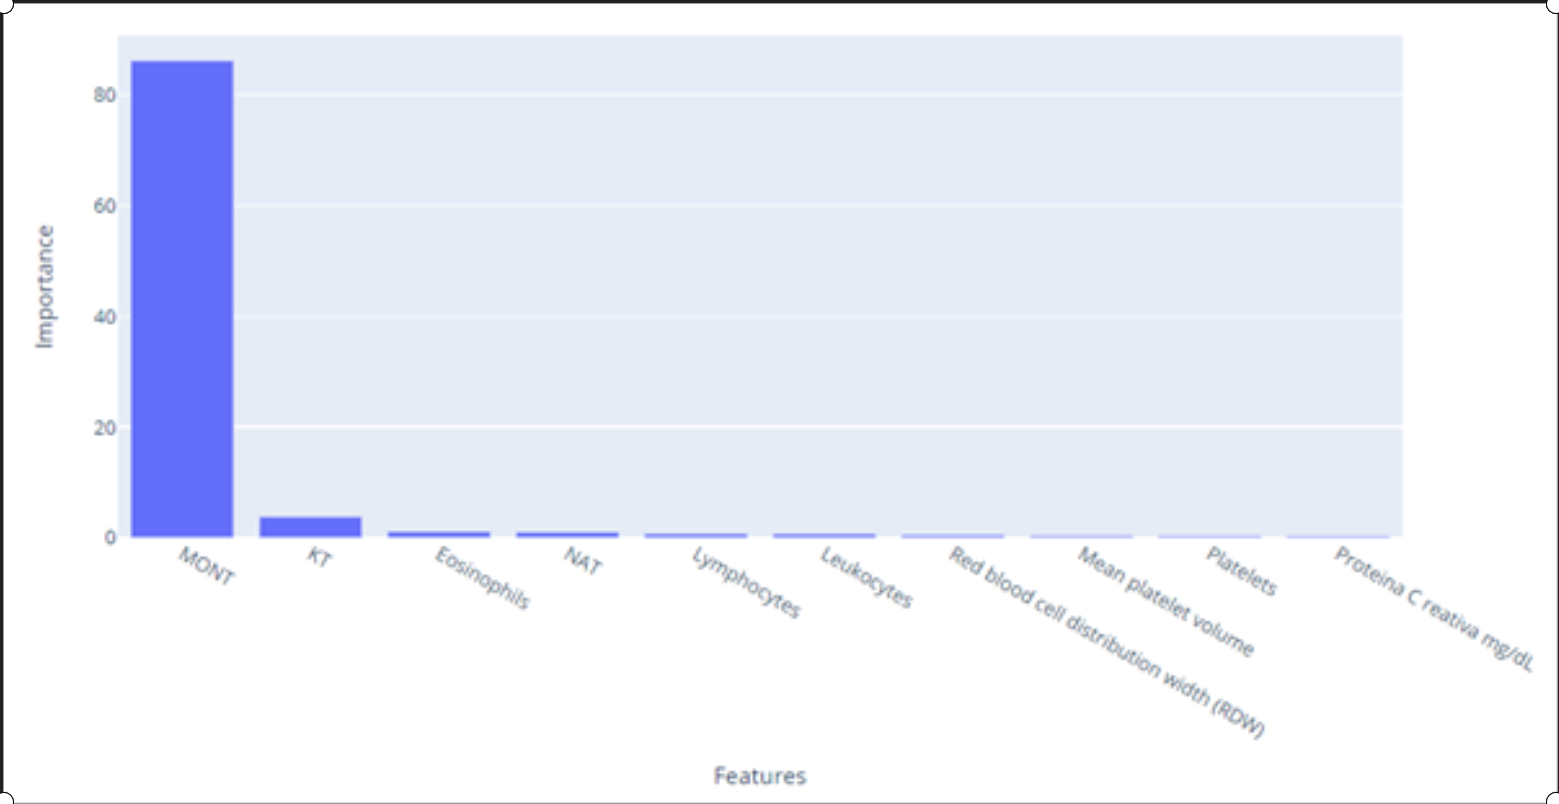

In [135]:
feat_imp.sort_values(['Importance'],ascending=False).head(10)

,Features,Importance
54,MONT,86.20
53,KT,3.77
52,Eosinophils,1.06
51,NAT,0.99
50,Lymphocytes,0.70
49,Leukocytes,0.67
48,Red blood cell distribution width (RDW),0.48
47,Mean platelet volume,0.40
46,Platelets,0.37
45,Proteina C reativa mg/dL,0.35


**Observation :** Monocytes is identified to have the most influence when comes to determine the type of wards for the infected patients.
Monocytes are a type of leukocyte, or white blood cell. According to an article, Monocytes is a great influencer of disease severity. 

https://mdhs.unimelb.edu.au/research/2018/medical-projects-by-theme/student-research-project/monocytes-in-covid-19-the-great-influencer-of-disease-severity

This shows that our hypertuned model has given us an accurate result, allowing us to learn about this feature and to investigate into it.  


**5.8 Feature Selection**

In [83]:
# use feature importance for feature selection

class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

# fit model on all training data
model = xgb
model.fit(X_smote_train, y_smote_train)
# make predictions for test data and evaluateX_smote_test
predictions = model.predict(X_smote_test)
accuracy = accuracy_score(y_smote_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_smote_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_smote_train)
    # eval model
    select_X_test = selection.transform(X_smote_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_smote_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=55, Accuracy: 92.92%
Thresh=0.000, n=47, Accuracy: 92.90%
Thresh=0.000, n=46, Accuracy: 92.90%
Thresh=0.000, n=45, Accuracy: 92.95%
Thresh=0.000, n=44, Accuracy: 92.90%
Thresh=0.000, n=43, Accuracy: 92.88%
Thresh=0.000, n=42, Accuracy: 92.83%
Thresh=0.000, n=41, Accuracy: 92.76%
Thresh=0.000, n=40, Accuracy: 92.79%
Thresh=0.000, n=39, Accuracy: 92.24%
Thresh=0.000, n=38, Accuracy: 91.78%
Thresh=0.000, n=37, Accuracy: 90.05%
Thresh=0.000, n=36, Accuracy: 90.14%
Thresh=0.000, n=35, Accuracy: 88.70%
Thresh=0.000, n=34, Accuracy: 88.58%
Thresh=0.001, n=33, Accuracy: 88.20%
Thresh=0.001, n=32, Accuracy: 88.22%
Thresh=0.001, n=31, Accuracy: 88.15%
Thresh=0.001, n=30, Accuracy: 82.49%
Thresh=0.001, n=29, A

**Observation :** The performance of the model generally decreases with the number of selected features, except when the number of features reached 45. We can try to drop the bottom 11 columns of the feature importance, to see if the accuracy will increase.

**5.9 Xgboost Prediction after dropping least important features**

In [126]:
#Define bottom 11 least important features to reduce columns to 45
drop_feat=feat_imp.sort_values(['Importance'],ascending=False).tail(11)
drop_feat_list=drop_feat['Features'].values.tolist()

In [127]:
#Drop columns using the drop_feat list
covid_feat=covid_final.drop(drop_feat_list, axis = 1)
covid_feat.shape

(5644, 45)

In [129]:
# Smote data using revised dataset
X1 = covid_feat.drop(['Ward'], axis = 1)
y1 = covid_feat['Ward']
smote = SMOTE()
X1_smote, Y1_smote = smote.fit_resample(X, y)


print("====================    y1_smote    ==========================") 
#Checking of data distribution
counter = Counter(Y1_smote)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Ward = %d, n = %d, Percentage = %.3f%%' % (k, v, per))
X1_smote_train, X1_smote_test, y1_smote_train, y1_smote_test = train_test_split(X1_smote, Y1_smote, test_size = 0.2, random_state = 22)


====================    y1_smote    ==========================
Ward = 0, n = 5474, Percentage = 96.988%
Ward = 2, n = 5474, Percentage = 96.988%
Ward = 1, n = 5474, Percentage = 96.988%
Ward = 3, n = 5474, Percentage = 96.988%


In [130]:
#Fit Model
xgb.fit(X1_smote_train, y1_smote_train)
#Generate predictions with the model using our X values
y1_tune_pred = xgb.predict(X1_smote_test)
y1_tune_prob = xgb.predict_proba(X1_smote_test)

print(classification_report(y1_smote_test, y1_tune_pred))
print("Accuracy :",metrics.accuracy_score(y1_smote_test, y1_tune_pred))
print("Balanced Accuracy :",metrics.balanced_accuracy_score(y1_smote_test, y1_tune_pred))
#roc auc score for each ward
tune_roc_auc=roc_auc_score_multiclass(y1_smote_test, y1_tune_pred)
roc_auc_tune=pd.DataFrame.from_dict(tune_roc_auc,orient='index',columns=['After Tune'])

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1129
           1       0.93      0.91      0.92      1091
           2       1.00      0.92      0.96      1094
           3       0.88      0.99      0.93      1066

    accuracy                           0.94      4380
   macro avg       0.94      0.94      0.94      4380
weighted avg       0.94      0.94      0.94      4380

Accuracy : 0.9351598173515981
Balanced Accuracy : 0.9356553371152411


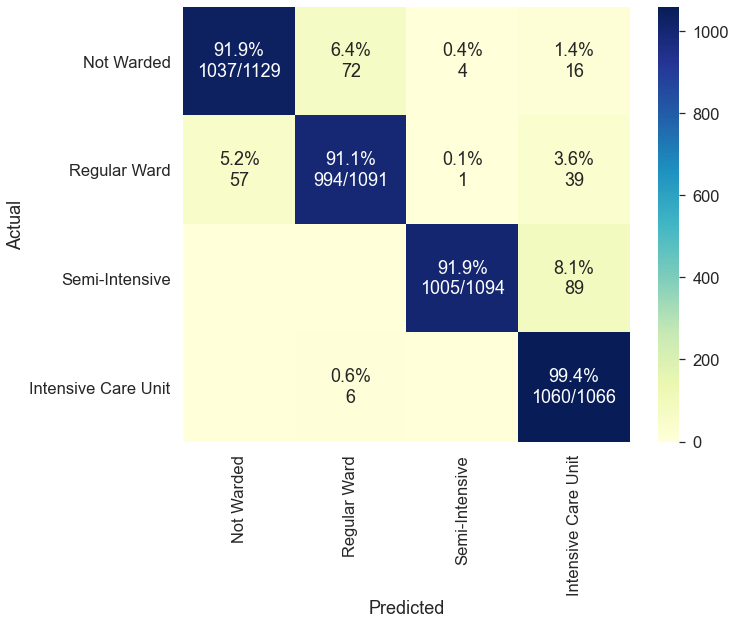

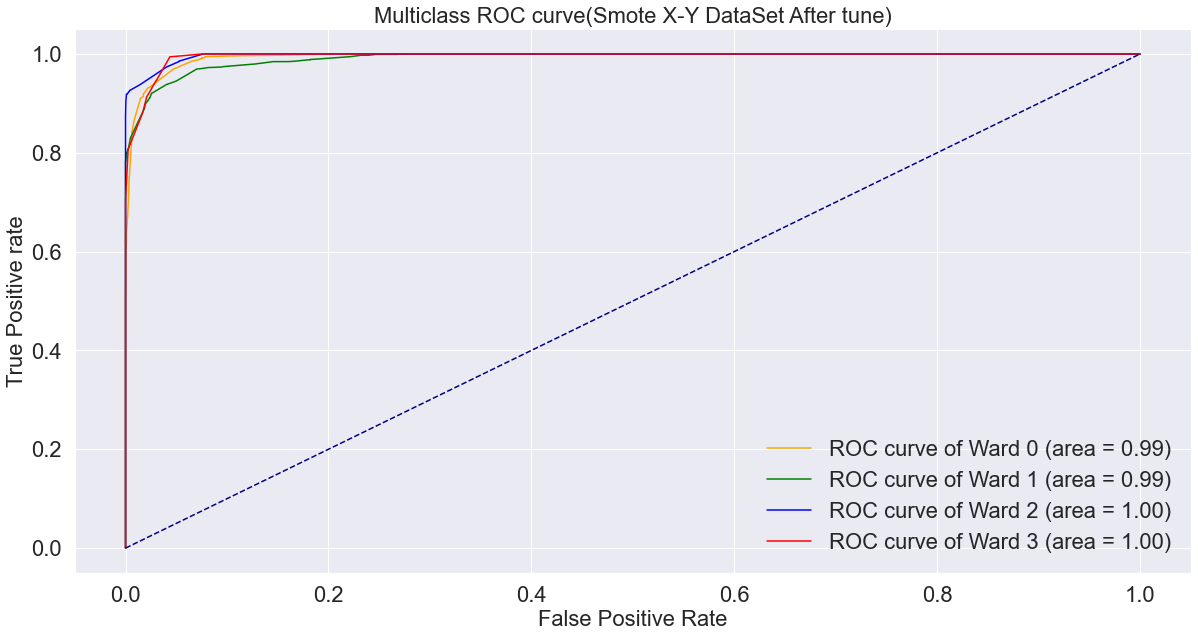

In [131]:
 # Visualize confusion matrix
plot_cm(y1_smote_test, y1_tune_pred)


# Visualizing ROC Curve

fpr2 = {}
tpr2 = {}
thresh2 ={}
roc_auc2={}


for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y1_smote_test, y1_tune_prob[:,i], pos_label=i)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
#    
plt.rcParams["figure.figsize"] = (20,10)

#Plotting of line graph
plt.plot(fpr2[0], tpr2[0], linestyle='-',color='orange', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(0, roc_auc2[0]))
plt.plot(fpr2[1], tpr2[1], linestyle='-',color='green', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(1, roc_auc2[1]))
plt.plot(fpr2[2], tpr2[2], linestyle='-',color='blue', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(2, roc_auc2[2]))
plt.plot(fpr2[3], tpr2[3], linestyle='-',color='red', label='ROC curve of Ward {0} (area = {1:0.2f})'
             ''.format(3, roc_auc2[3]))

plt.title('Multiclass ROC curve(Smote X-Y DataSet After tune)',fontsize=22)
plt.xticks(fontsize=22 )
plt.yticks(fontsize=22 )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive rate',fontsize=22)
plt.legend(loc='best',fontsize=22)
plt.savefig('Multiclass ROC',dpi=300); 

**Observation :** From the classification report, confusion matrix and ROC curve, we can determine that the overall scoring and accuracy improved after reducing the columns to 45, by removing the 11 least importance features. 


**Summary**

Ward | AUC Before Columns Reduction |  AUC After Columns Reduction | Variance
:-:|:-|:-|:-
0 | 0.99 | 0.99 | 0.00
1 | 0.99 | 0.99 | 0.00
2 | 1.00 | 1.00 | 0.00
3 | 0.99 | 1.00 | 0.01

Ward | Before Columns Reduction |  After Columns Reduction | Variance
:-:|:-|:-|:-
Accuracy | 0.9292237442922374 | 0.9351598173515981 | +0.0059361
Balanced Accuracy | 0.9296621526079807 | 0.9356553371152411 | +0.0059932

 

**Recap and Conclusions**
XGBoost classifier is the best performing model among the top 3 models selected from the lazy predict using manual comparison based on the balanced accuracy of each after tuned model. It also produces a better ROC curve and AUC, as compared to the other models.

Managing large missing values, smote the entire data to tackle the imbalance data, develop multi-class target and understanding viruses and grouping them. 

We saw little to no predictions  initially, but after we perform thorough cleaning, it has significantly improves our data quality.  

Lazy Predict has been used to identify machine learning models and evaluating the performance metrics. 

After hyperturne the chosen models, we use Max Voting to combine multiple machines to make prediction and vote the best. 

XGboost is the best model and was hypertuned before conducting Feature Importance. The final result we gotten is 0.93%

**If we were to do it again, we will try this approach**
After we had treated the data, we would go with a Bayesian Neural Network (BNN), given that it would take all the inputs into consideration and predict the wards. 

BNN is said to take a probabilistic approach to deep learning that account for uncertainty due to measurement error, noise in the label or insufficient data availability for the model to learn effectively. 

PyMC3 Library to fit BNN and is something to explore and also  implement cutting edge inference algorithms. 
